In [1]:
import os   #used for directory work
import matplotlib.patches as mpatches #used for plot legends
import matplotlib.pyplot as plt #used for creating plots
import matplotlib.cm as cm
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#path="/home/joey/Desktop/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/" #79 location#
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/" #w10 location
def text_finder(path):
    txt_files=[]
    all_files = os.listdir(path) #tells what directory the files are in
    for i in all_files: #reading only the .txt files 
        if i[-4:] == ".txt":
            txt_files.append(i)
    txt_files.sort() #alphabetizes them
    return txt_files

#txt_files = text_finder(path)
#df = pd.read_csv(path + txt_files[0],na_values = ['NAN', "00nan"], sep="\t")  



In [3]:
def calculations(df,n,time_steps = "10s"):
    timestamp_lst, speed = [],[]
    for t in range(len(df)):
        timestamp_lst.append(pd.Timestamp(str(df["YYYY"][t])+"-"+str(df["MM"][t])+"-"+str(df["DD"][t]) +" "+str(df["Hr"][t])+":"+str(df["Min"][t])+":"+str(df["Sec"][t]),freq = ".1S"))
        speed.append(np.sqrt((df["U"][t])**2+(df["V"][t])**2))

    df_raw = pd.DataFrame()
    df_raw["Timestamp"] = timestamp_lst
    df_raw["W"]=df["W"]
    df_raw["S"]=speed
    df_raw["T"]=df["T"]

    #### Calculating the W', T' averages

    W_average = np.mean(df["W"][:n])
    S_average = np.mean(df_raw["S"][:n])

    W_prime, S_prime= [], []
    for i in range(len(df)):
        W_prime.append(df["W"][i]-W_average)
        S_prime.append(df_raw["S"][i]-S_average)

    ### Making the Quad list for all the points
    quad, quad_mag = [],[] 
    for i in range(len(df_raw)):
        quad_mag.append(abs(W_prime[i]*S_prime[i]))
        if float(W_prime[i]) > 0 and float(S_prime[i]) > 0:
            quad.append(1)
            continue
        if float(W_prime[i]) > 0 and float(S_prime[i]) < 0:
            quad.append(2)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) < 0:
            quad.append(3)
            continue
        if float(W_prime[i]) < 0 and float(S_prime[i]) > 0:
            quad.append(4)
            continue
        else:
            quad.append(0)


    df_raw["Quad"] = quad
    df_raw["Quad_Mag"] = quad_mag
    df_raw = df_raw.set_index("Timestamp")

    n_per_10s=list(df_raw.resample(time_steps).count()["W"])

    counter = 0
    q1_mag, q2_mag = [], [] 
    q3_mag, q4_mag = [], []
    q_sum = []
    for a in n_per_10s:
        q1, q2 = 0, 0 
        q3, q4 = 0, 0
        for n in range(counter,counter+a):
            if df_raw["Quad"][n] == 1:
                q1+=df_raw["Quad_Mag"][n]

            if df_raw["Quad"][n] == 2:
                q2+=df_raw["Quad_Mag"][n]

            if df_raw["Quad"][n] == 3:
                q3+=df_raw["Quad_Mag"][n]

            if df_raw["Quad"][n] == 4:
                q4+=df_raw["Quad_Mag"][n]
        q_sum.append(q1+q2+q3+q4)
        if a != 0 :
            
            q1_mag.append(q1/a)
            q2_mag.append(-1*q2/a)
            q3_mag.append(q3/a)
            q4_mag.append(-1*q4/a)
        if a == 0:
            q1_mag.append(0)
            q2_mag.append(0)
            q3_mag.append(0)
            q4_mag.append(0)
            
        counter = counter + int(a)

    ## W'T' 
    ws = []
    for i in range(len(df)):
        ws.append(W_prime[i]*S_prime[i])

    df_prime = pd.DataFrame()
    df_prime["Timestamp"] = timestamp_lst
    df_prime["W'S'"]= ws
    df_prime = df_prime.set_index("Timestamp")

    df_plot = df_prime.resample(time_steps).mean()


    x_tick_loc, x_tick_label = [], []
    for i in range(0,len(df_plot),len(df_plot)//5):
        x_tick_loc.append(i)
        x_tick_label.append(str(df_plot.index[i])[-9:])

    x = np.arange(0, len(q1_mag), 1)

    #Calculating the time of fire for each sonic
    T_resample = list(df_raw.resample(time_steps).mean()["T"])
    x_fire = 0
    for i in range(len(T_resample)):
        if T_resample[i] > (np.mean(T_resample)+5*np.std(T_resample)):
            x_fire = i+.5 
            break
    return x, x_fire, df_plot, q1_mag, q2_mag, q3_mag,q4_mag,x_tick_loc, x_tick_label

In [4]:
def grid(path,n,burn, seperator= " "):#,ymax=55,ymin=-10,seperator = " "):
    fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(28,16))#, sharex=True, sharey=True)
    txt_files = text_finder(path)
    file=0
    for col in range(4):
        for row in range(4):
            #read in the data and compute means
            df = pd.read_csv(path + txt_files[file],na_values = ['NAN', "00nan"], sep=seperator)  
            x, x_fire, df_plot, q1_mag, q2_mag, q3_mag,q4_mag,x_tick_loc, x_tick_label = calculations(df,n)
            #create the scatter subplots
            ax = axs[ col, row]

            #ax.plot(list(df_plot["W'S'"]), marker = "_",linewidth=.3,linestyle = "--", c = "k", markersize=.25)
            ax.bar(x,q2_mag,width = .8,label = "II (Ejection)",color = "indianred")
            ax.bar(x,q3_mag,width = .8,label = "III (Inward Int.)",color = "orange" ,bottom =q1_mag)
            ax.bar(x,q1_mag, width = .8,label = "I (Outward Int.)",color = "limegreen" )
            ax.bar(x,q4_mag, width = .8,label = "IV (Sweep)",color = "royalblue" ,bottom =q2_mag)
            ax.legend(ncol = 2,loc = 'lower center', bbox_to_anchor=(0.35, -.32), fontsize = 10,framealpha=0.3, markerscale = .7)
            
            #ax.vlines(n/100-.5,min(q4_mag),max(q1_mag) , color = "k",label =r"$\overline{PreBurn}$", linestyle = "--",linewidth = .5)
            #ax.vlines(x_fire, min(q4_mag),max(q1_mag), color = "darkred",label ="($T{}'$ $+6\sigma$)", linestyle = "--",linewidth = .5)
            
            #titles and formating 
            ax.set_title(txt_files[file][:2], fontsize = 14)
            ax.set_xlabel("Time", fontsize=12, position=(.85,0.4))
            ax.set_ylabel(r"Contribution W${}'$S${}'$ $(\frac{{m}^2}{{s}^2})$",rotation =90, fontsize=12,labelpad=0 )
    
            ax.vlines(n/100-.5,-.75,.75, color = "k",label =r"$\overline{PreBurn}$", linestyle = "--",linewidth = .5)
            ax.vlines(x_fire, -.75,.75 , color = "darkred",label ="($T{}'$ $+5\sigma$)", linestyle = "--",linewidth = .5)
            
            ax.set_ylim(-.75,.75)
            ax.set_xlim(0, len(q1_mag))
            ax.set_xticks(x_tick_loc)
            ax.set_xticklabels(x_tick_label)
            #ax.legend(ncol = 2,labels = ["I","II","III","IV"],title="Quadrant",loc='upper center', bbox_to_anchor=(0.12, 1.03), fontsize = 12,framealpha=0.3, markerscale = .7)
            file=file+1 #used to change the files
            
    #adjust the spacingof the plots 
    plt.subplots_adjust(hspace=.4,wspace=.3)       
    fig.suptitle(burn+' Magnitude Analysis of Momentum Flux ', fontsize = 22, x=0.5, y=0.92)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles[:2], labels[:2], loc= 'upper right',bbox_to_anchor=(.85, .94),ncol = 2, fontsize = 20)
    fig.savefig(burn+"_Mag-Momentum-Flux-Grid.png",dpi=450)
  
    

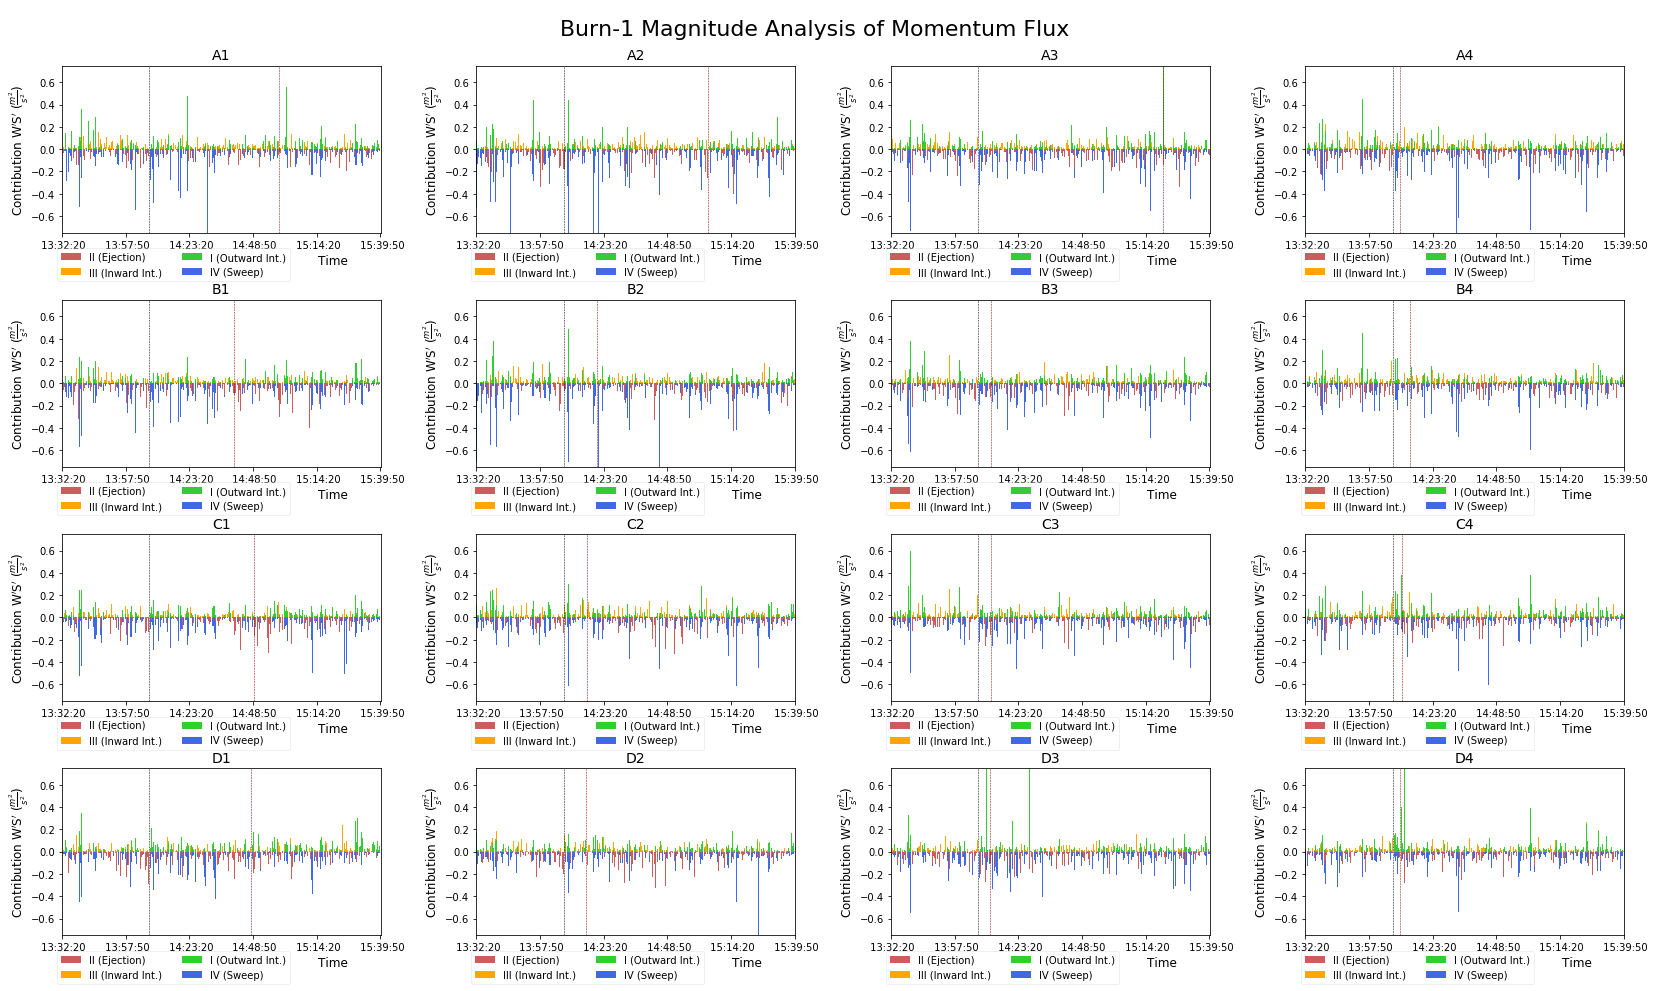

In [7]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-1/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-1/sonics/"  #134 location

grid(path,21000,"Burn-1")


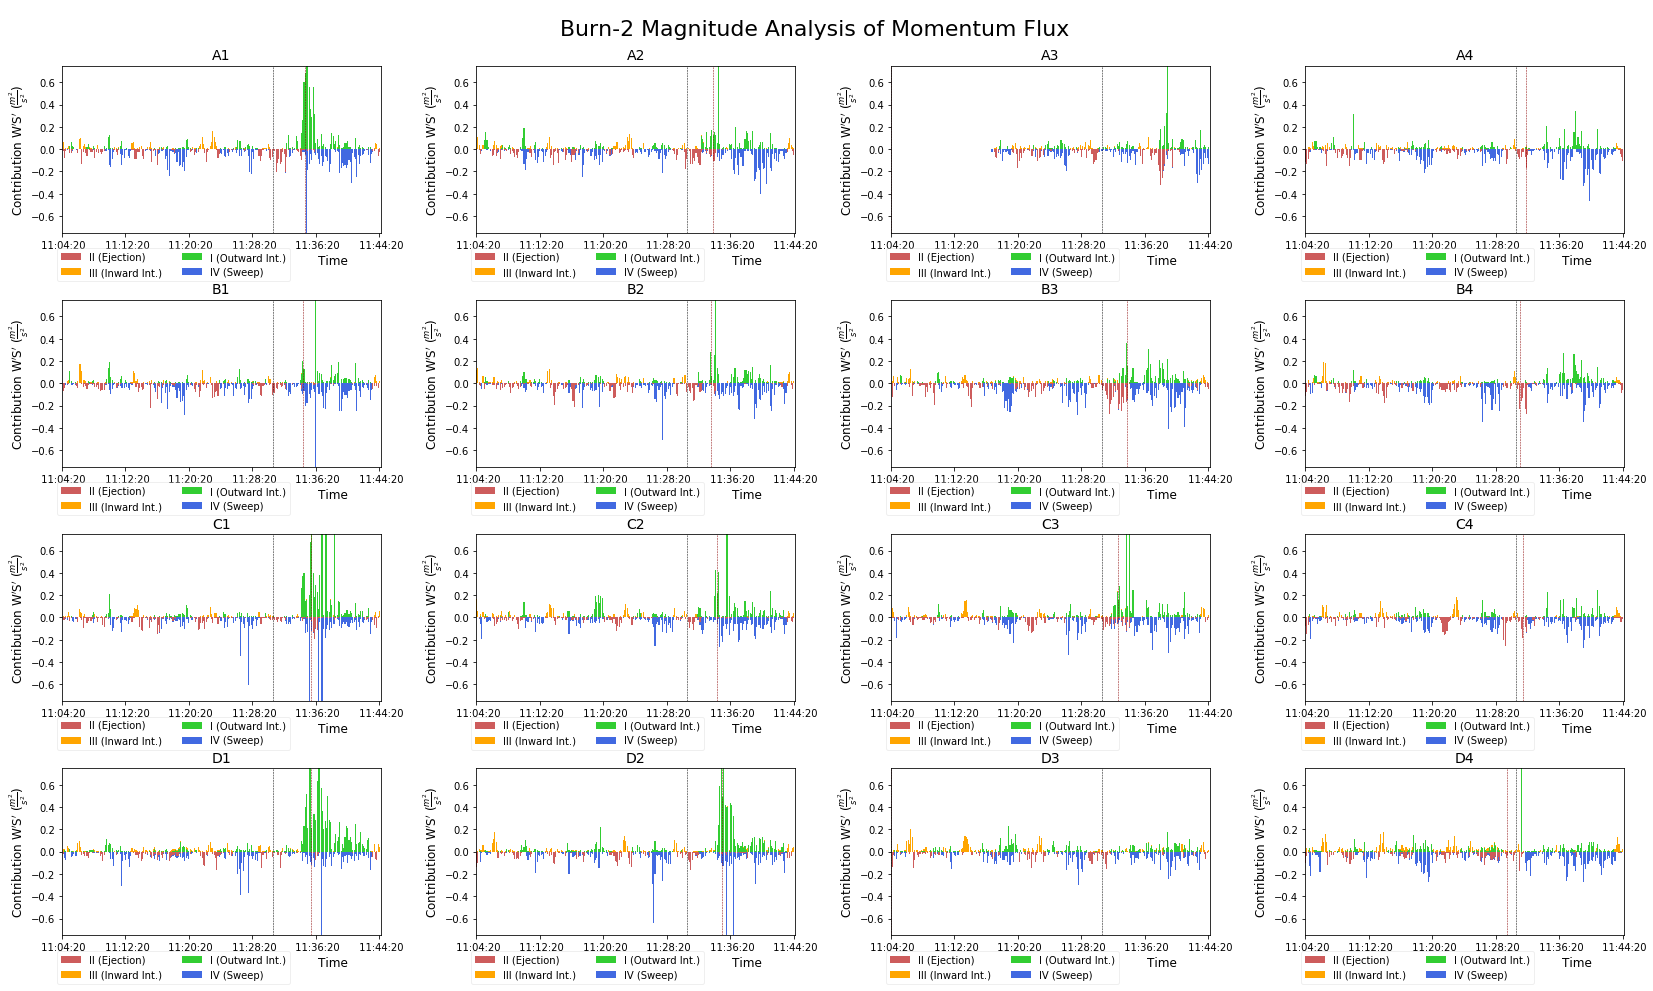

In [8]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-2/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-2/sonics/"  #134 location
grid(path, 16000,"Burn-2")

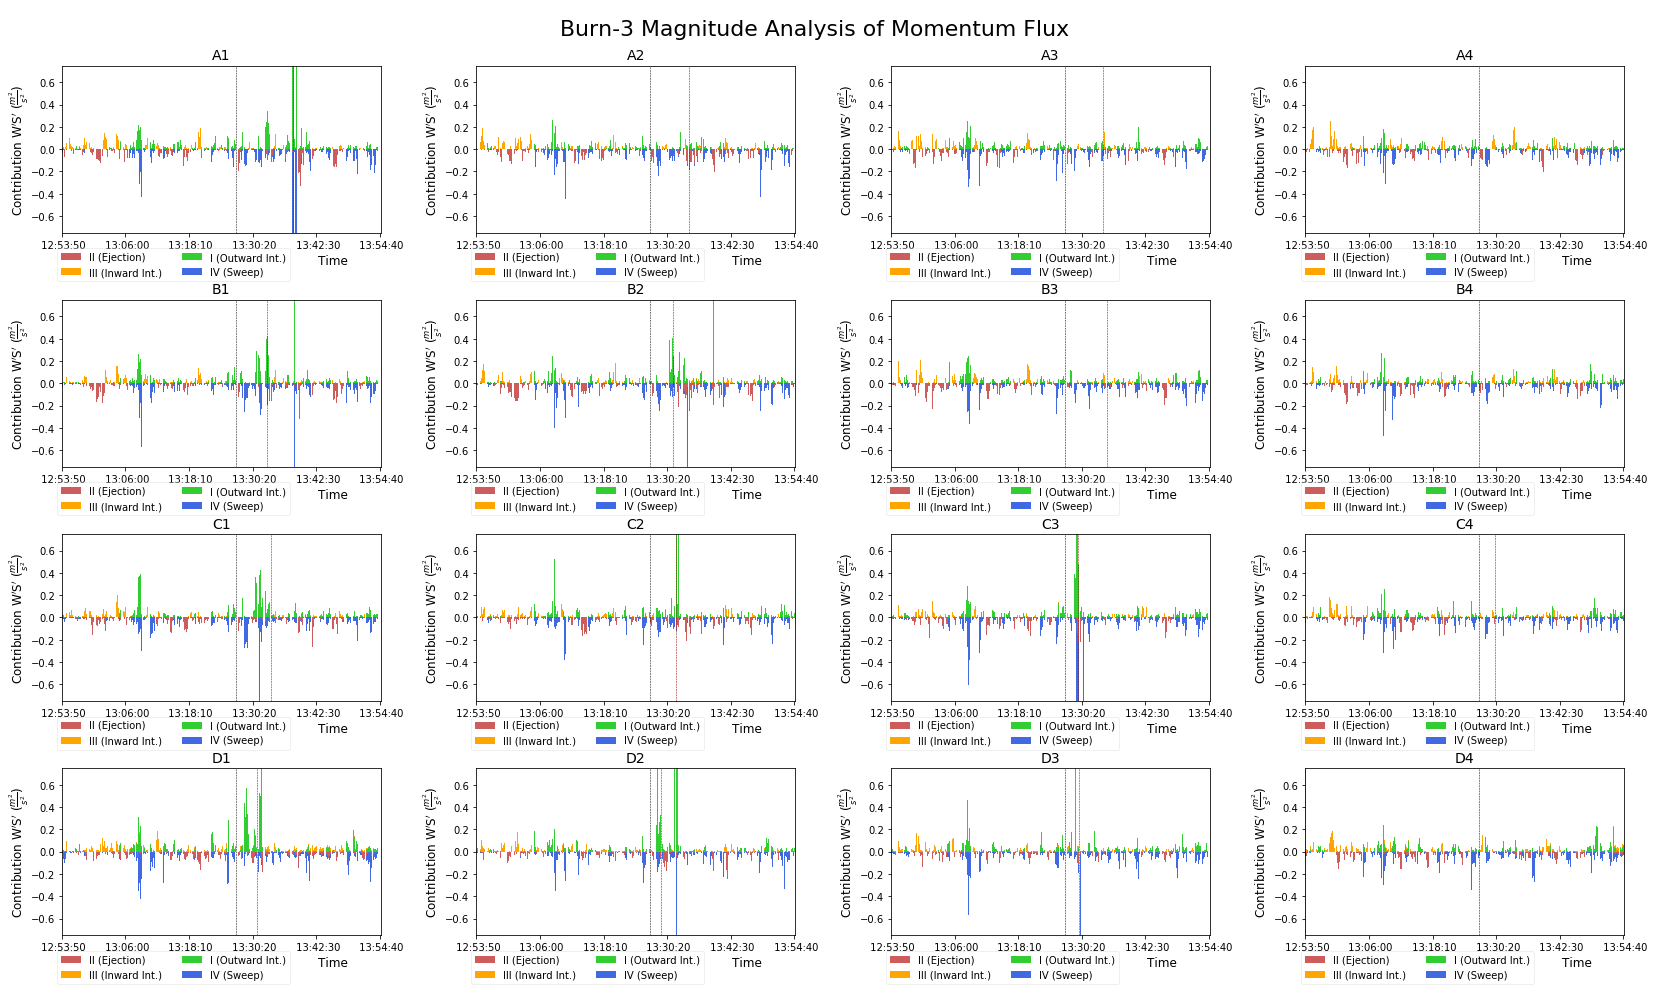

In [9]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-3/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-3/sonics/"  #134 location

#grid(path,20000,"Burn-3",True,seperator ="\t")
grid(path,20000,"Burn-3")

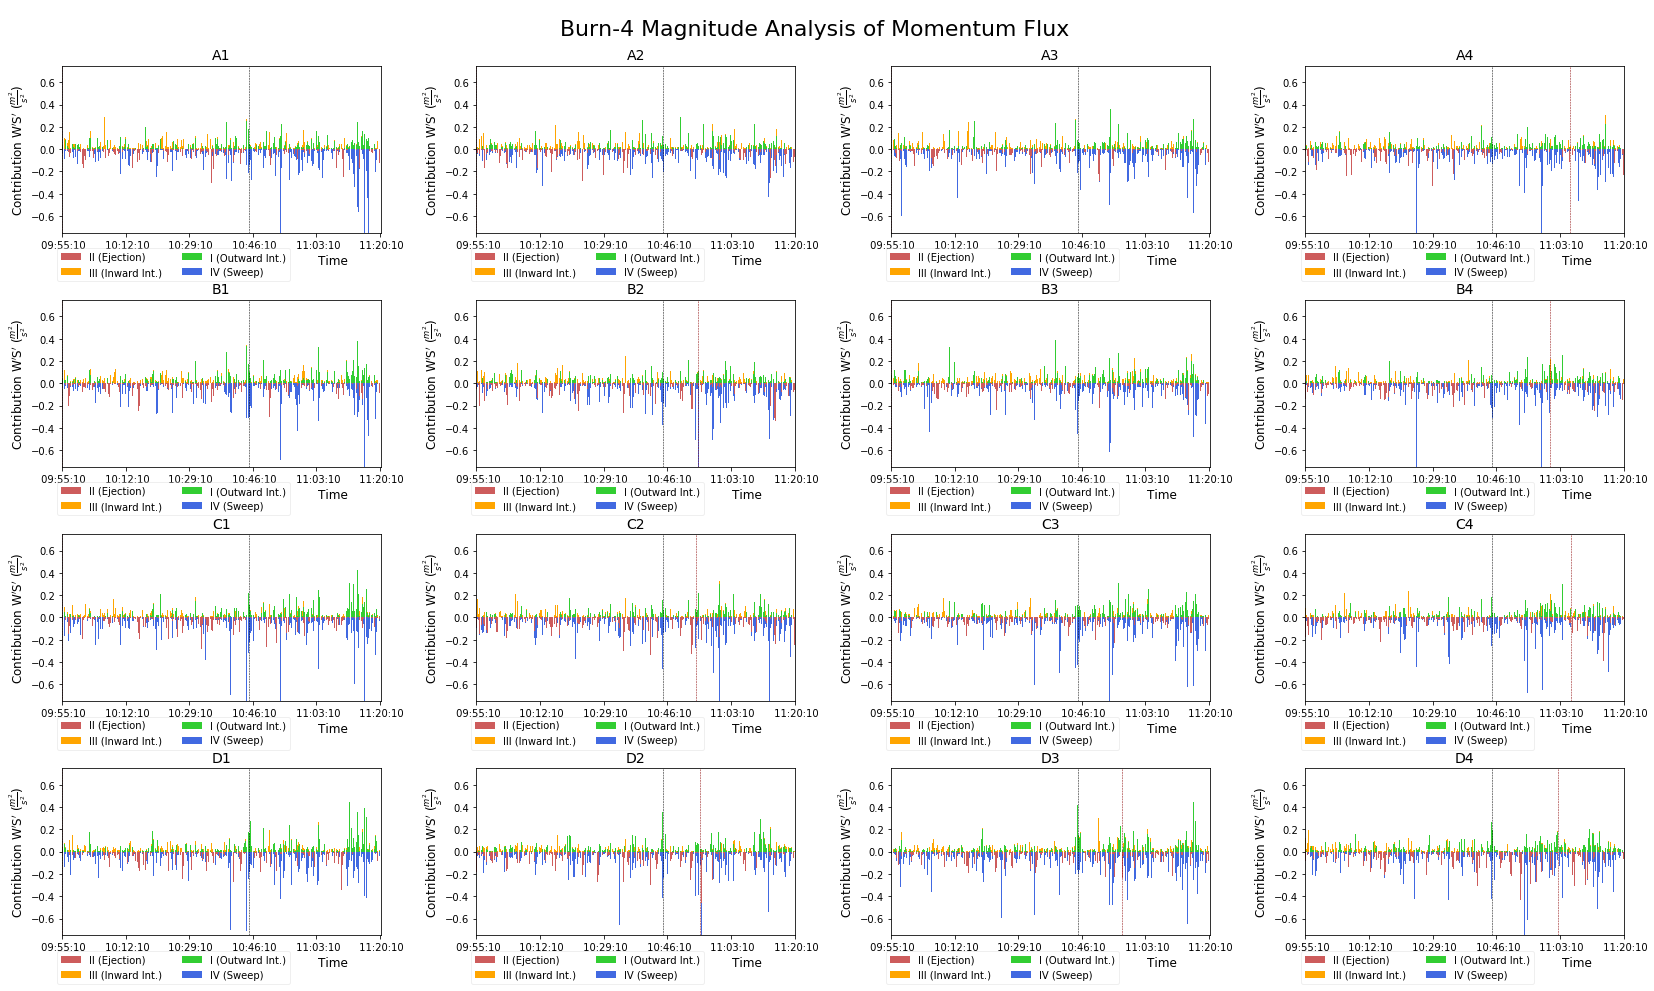

In [16]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-4/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-4/sonics/"  #134 location

#grid(path,30000,"Burn-4",True,seperator ="\t")
grid(path,30000,"Burn-4")

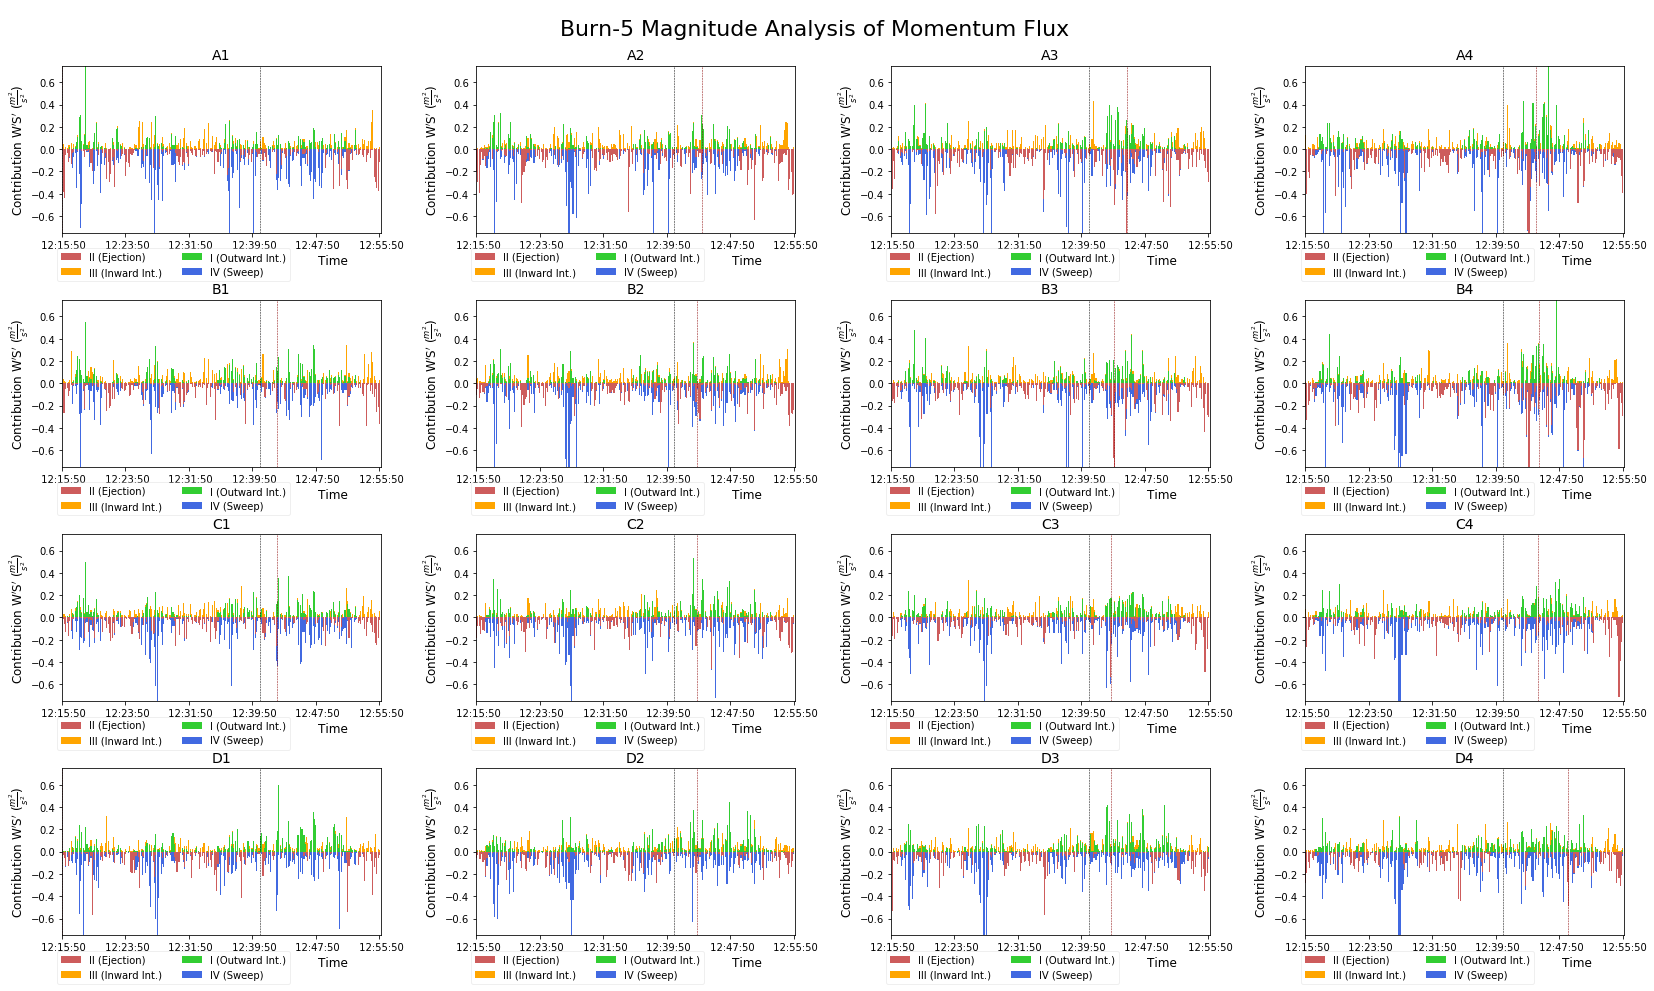

In [17]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-5/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-5/sonics/"  #134 location

#grid(path,15000,"Burn-5",True,seperator ="\t")
grid(path,15000,"Burn-5")

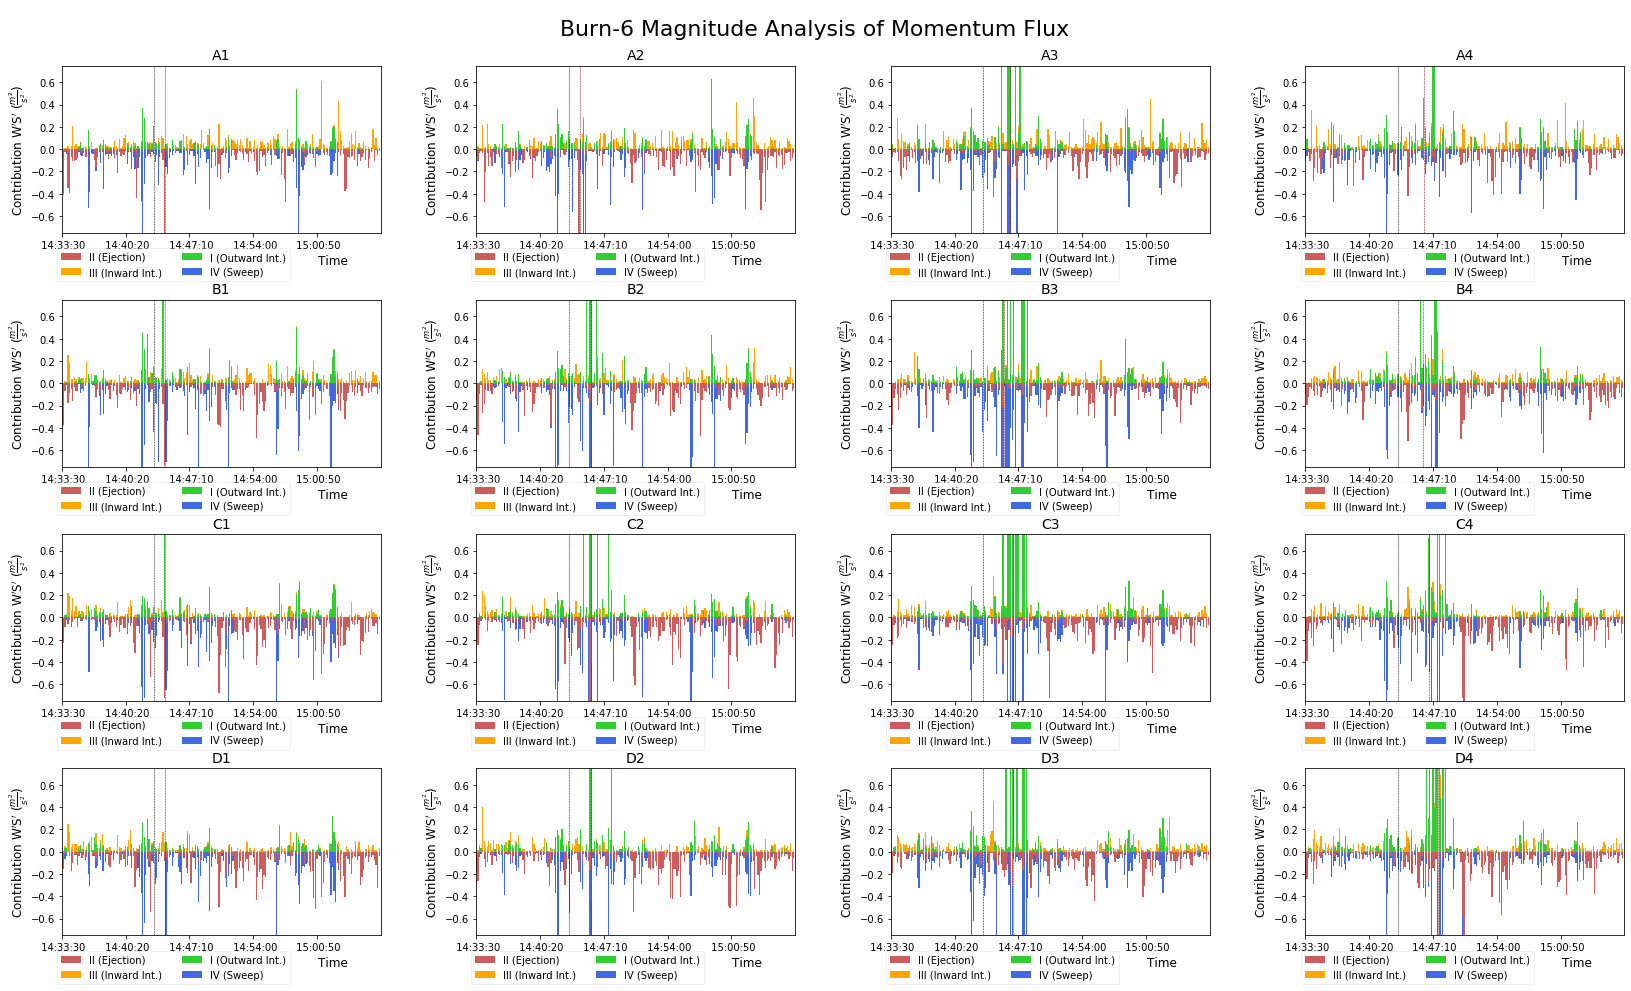

In [18]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-6/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-6/sonics/"  #134 location

#grid(path,6000,"Burn-6",True,seperator ="\t")
grid(path,6000,"Burn-6")

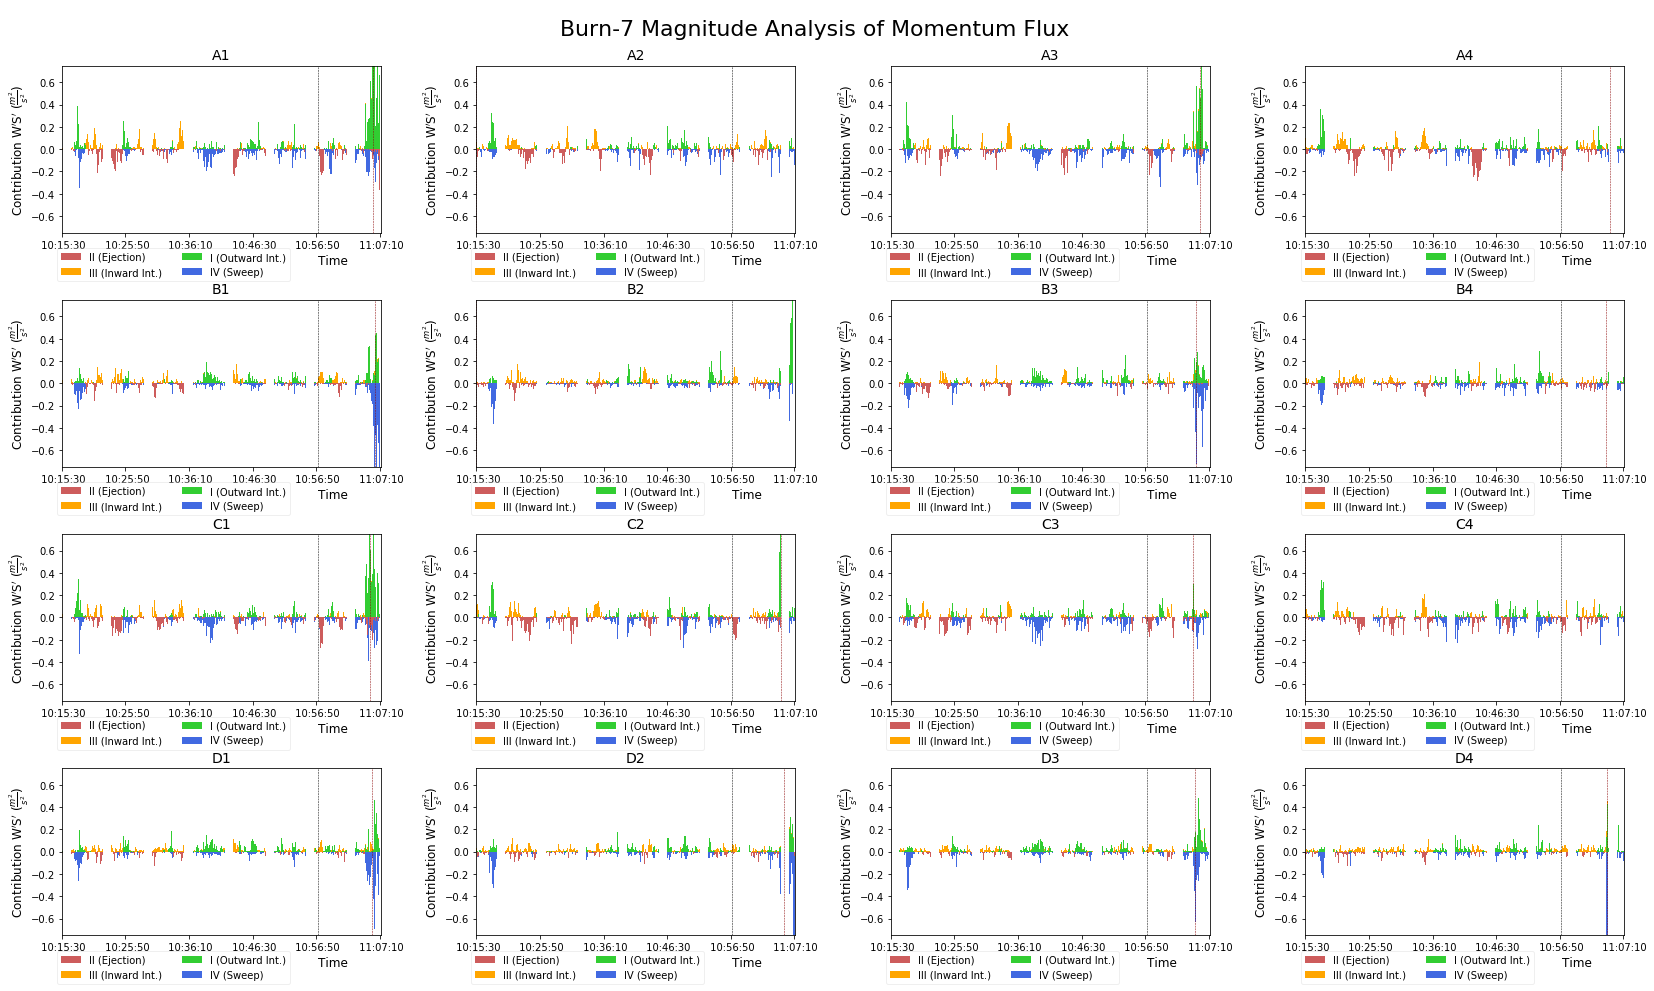

In [22]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-7/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-7/sonics/"  #134 location

#grid(path,25000,"Burn-7",True)
grid(path,25000,"Burn-7")

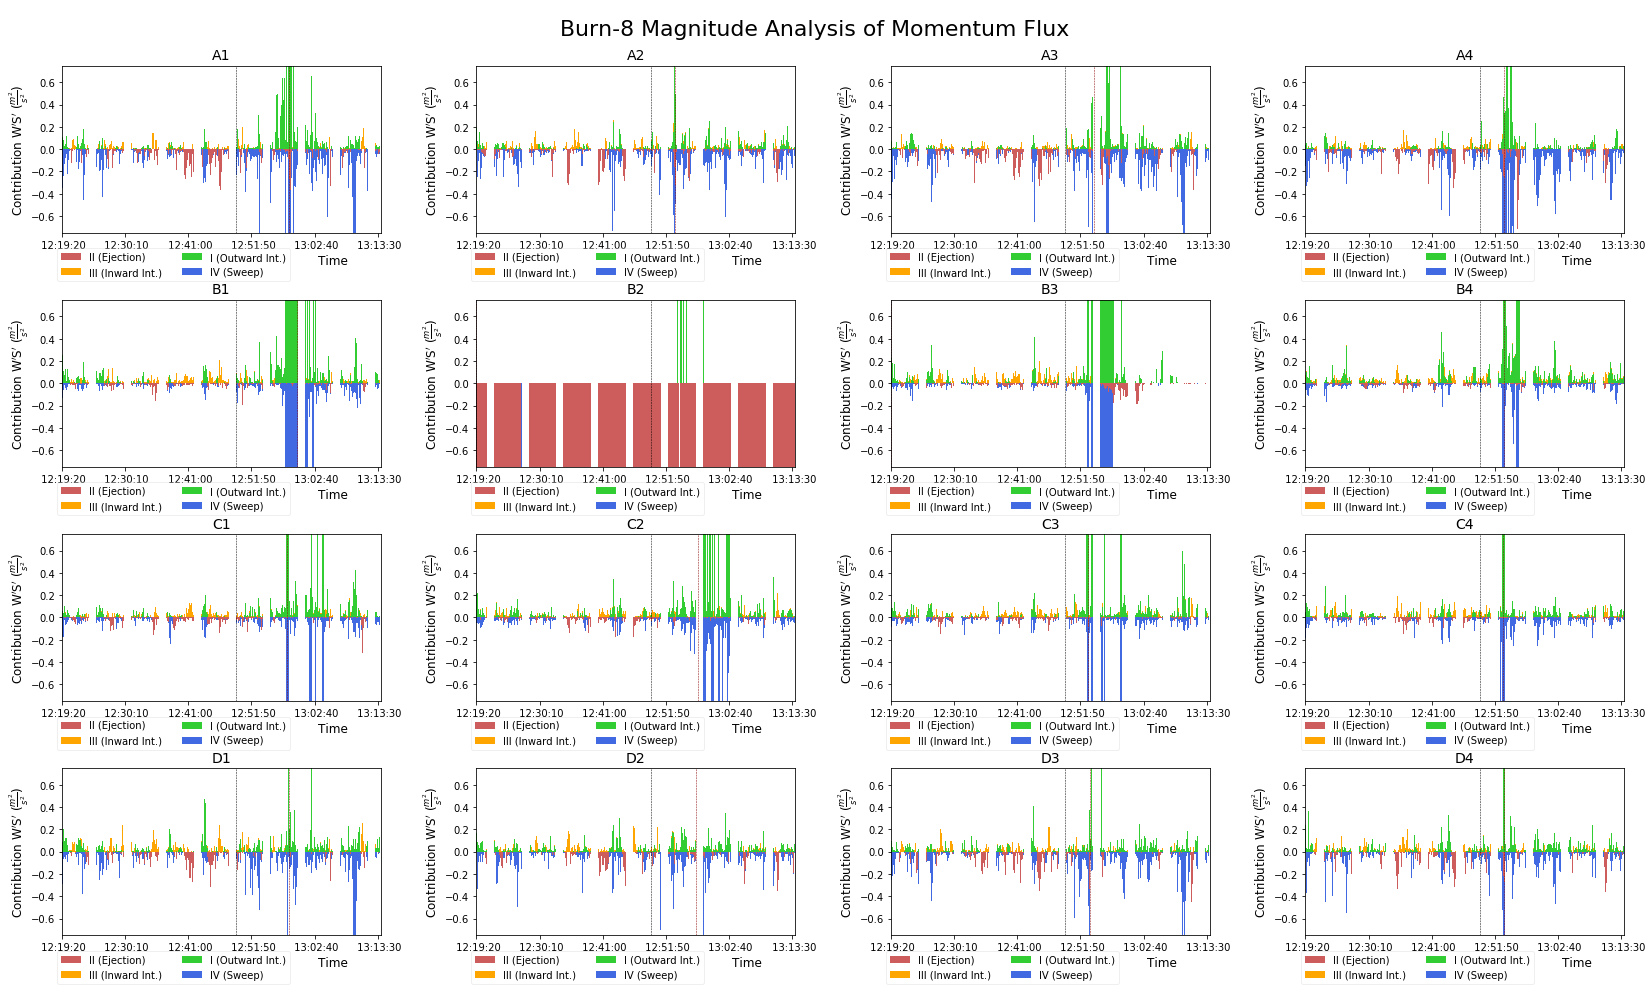

In [21]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-8/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-8/sonics/"  #134 location

#grid(path,18000,"Burn-8",True,seperator = "\t")
grid(path,18000,"Burn-8")

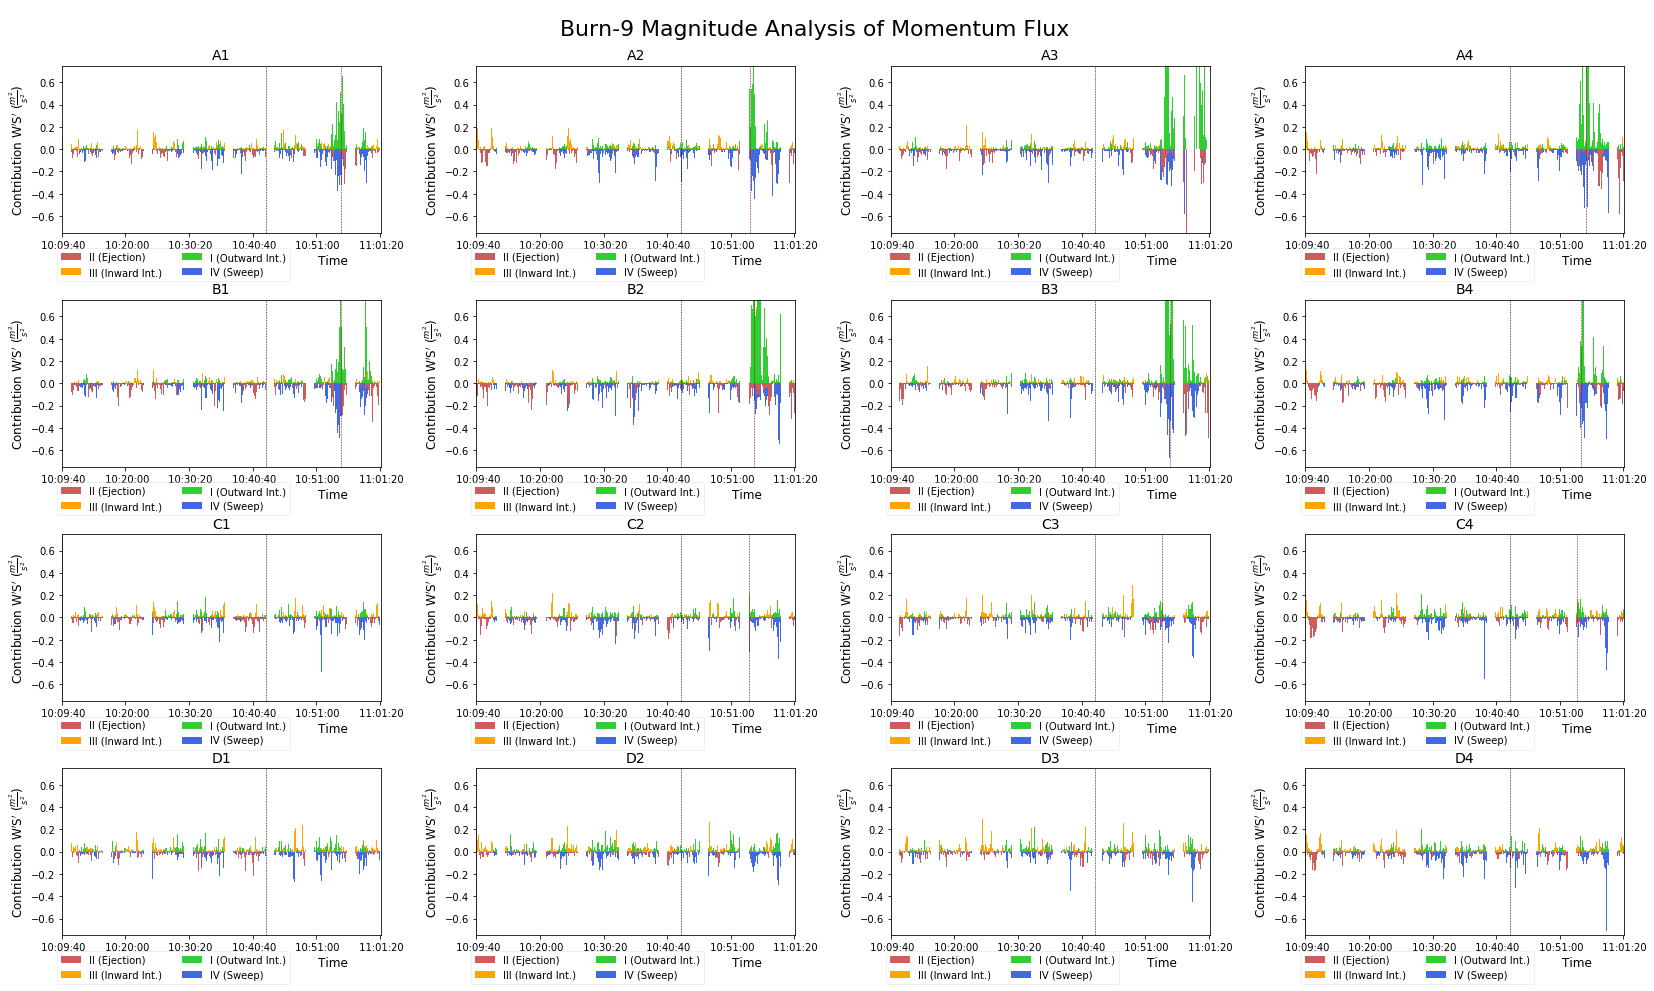

In [5]:
path= "/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Split-Times/Burn-09/sonics/"  #134 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-9/sonics/"  #134 location

#grid(path,20000,"Burn-9",True)#,seperator ="\t")
grid(path,20000,"Burn-9")

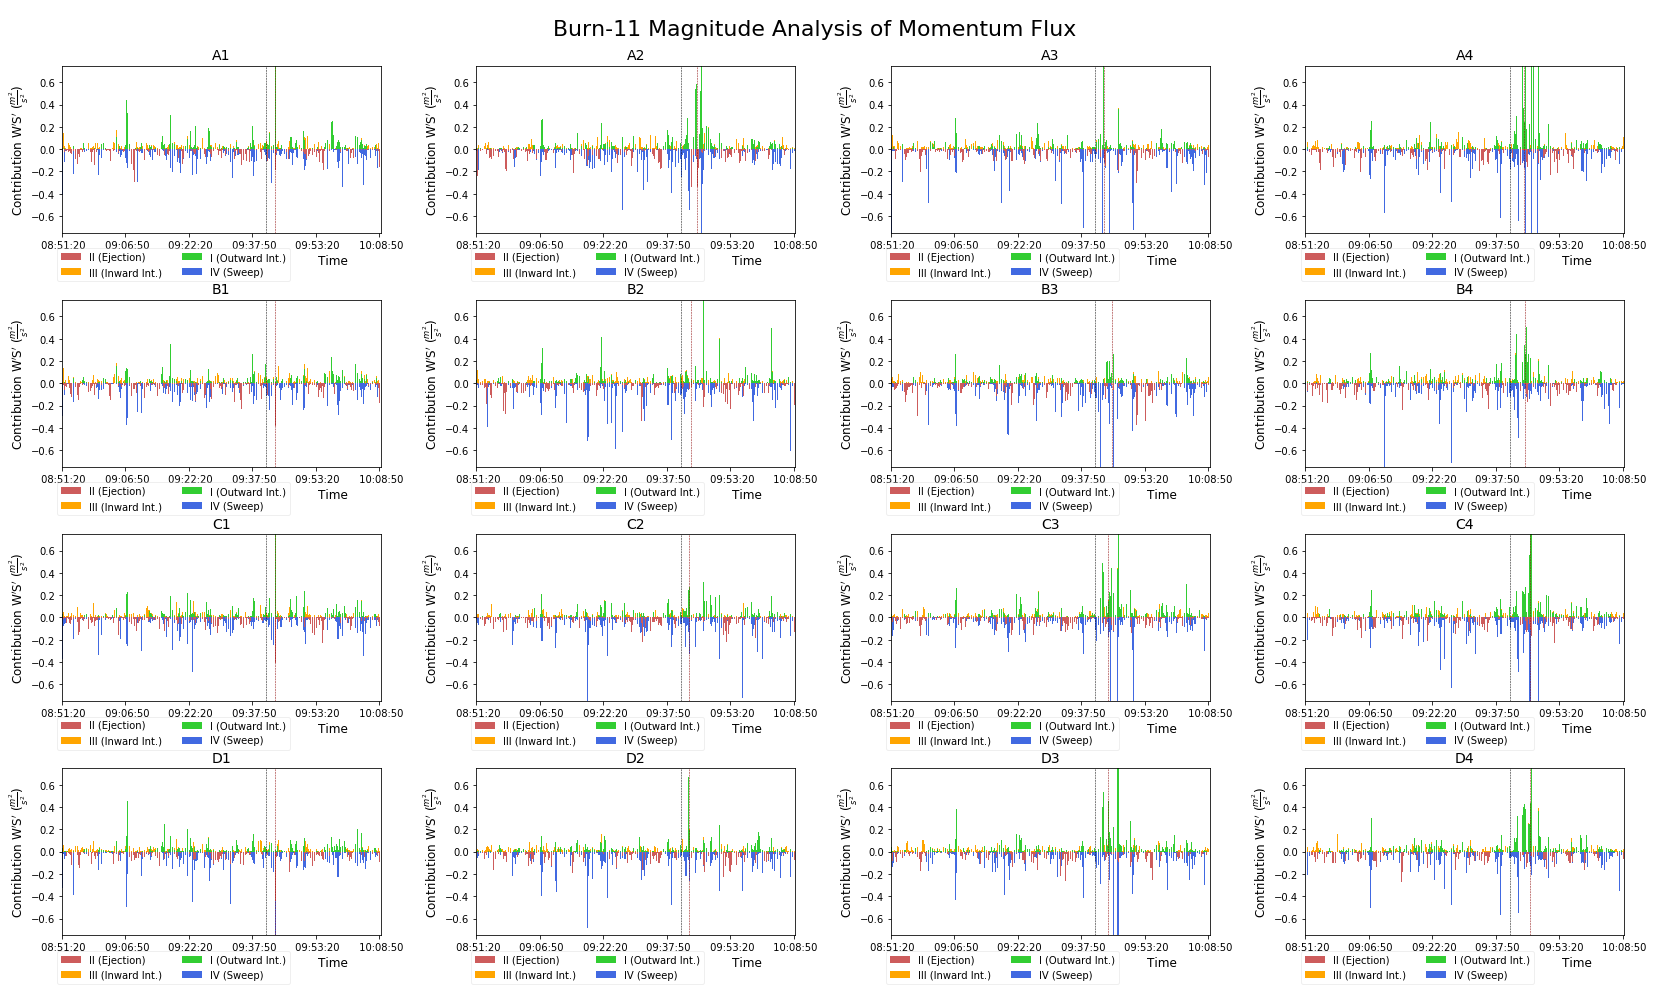

In [24]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-11/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-11/sonics/"  #134 location

#grid(path,30000,"Burn-11", True)
grid(path,30000,"Burn-11")

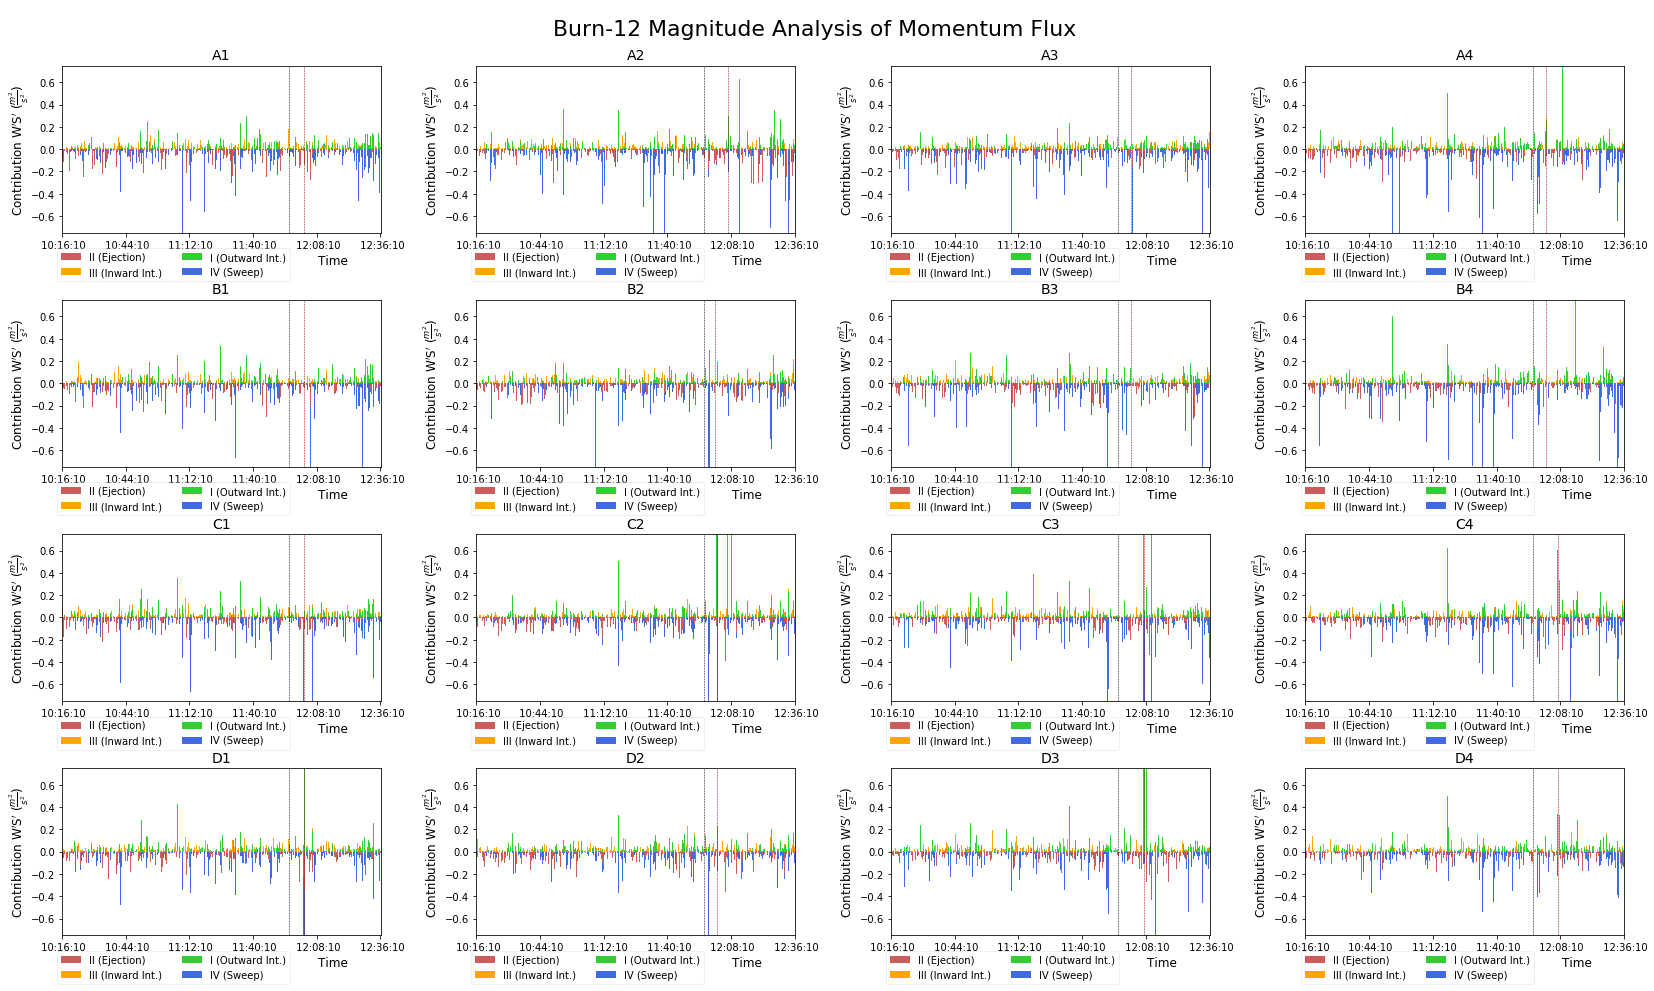

In [25]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-12/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-12/sonics/"  #134 location

#grid(path,60000,"Burn-12",True)
grid(path,60000,"Burn-12")

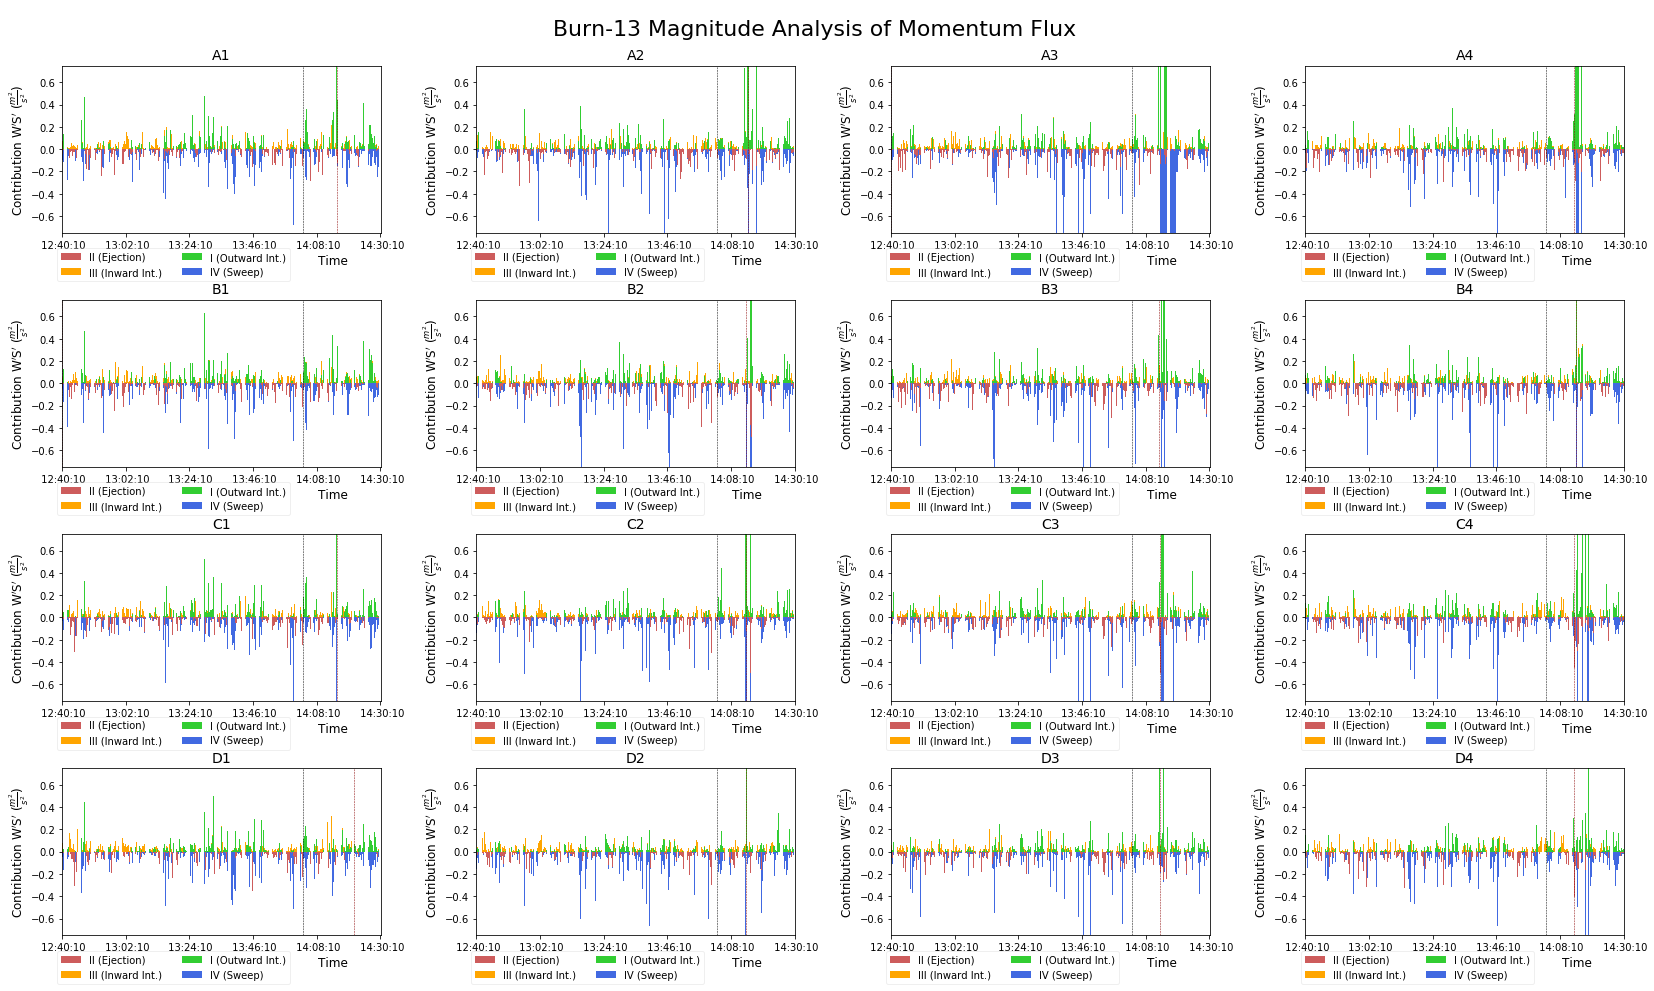

In [26]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

#grid(path,50000,"Burn-13",True)
grid(path,50000,"Burn-13")

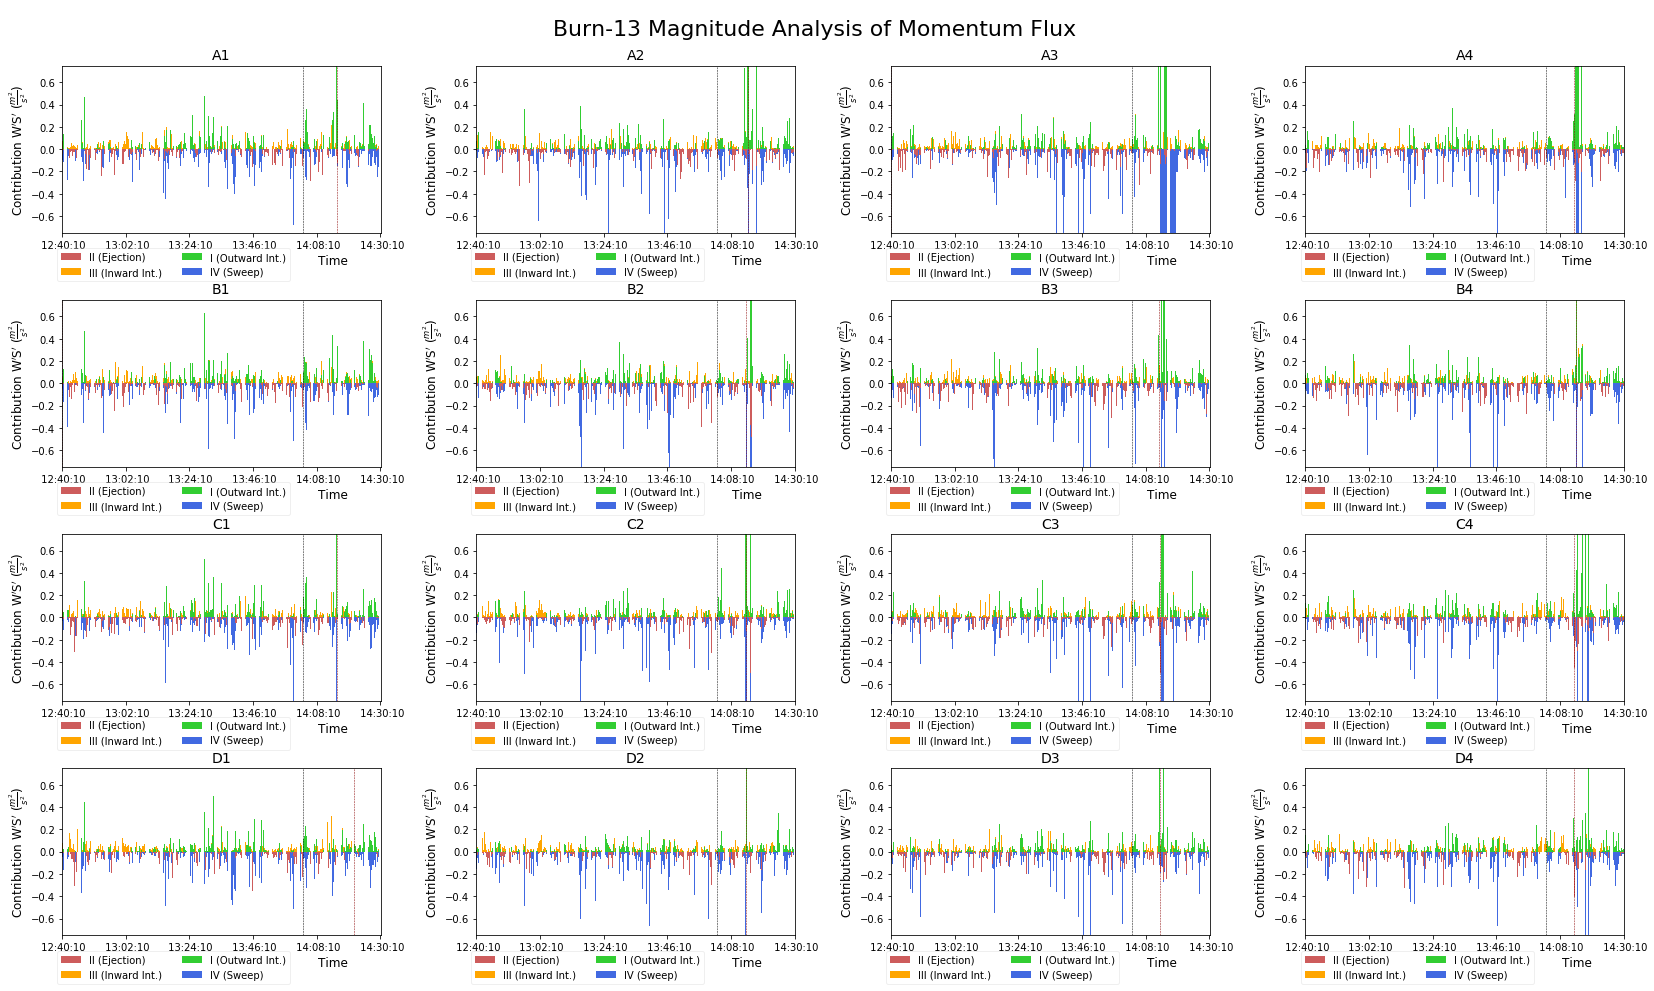

In [27]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-13/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

#grid(path,50000,"Burn-13",True)
grid(path,50000,"Burn-13")

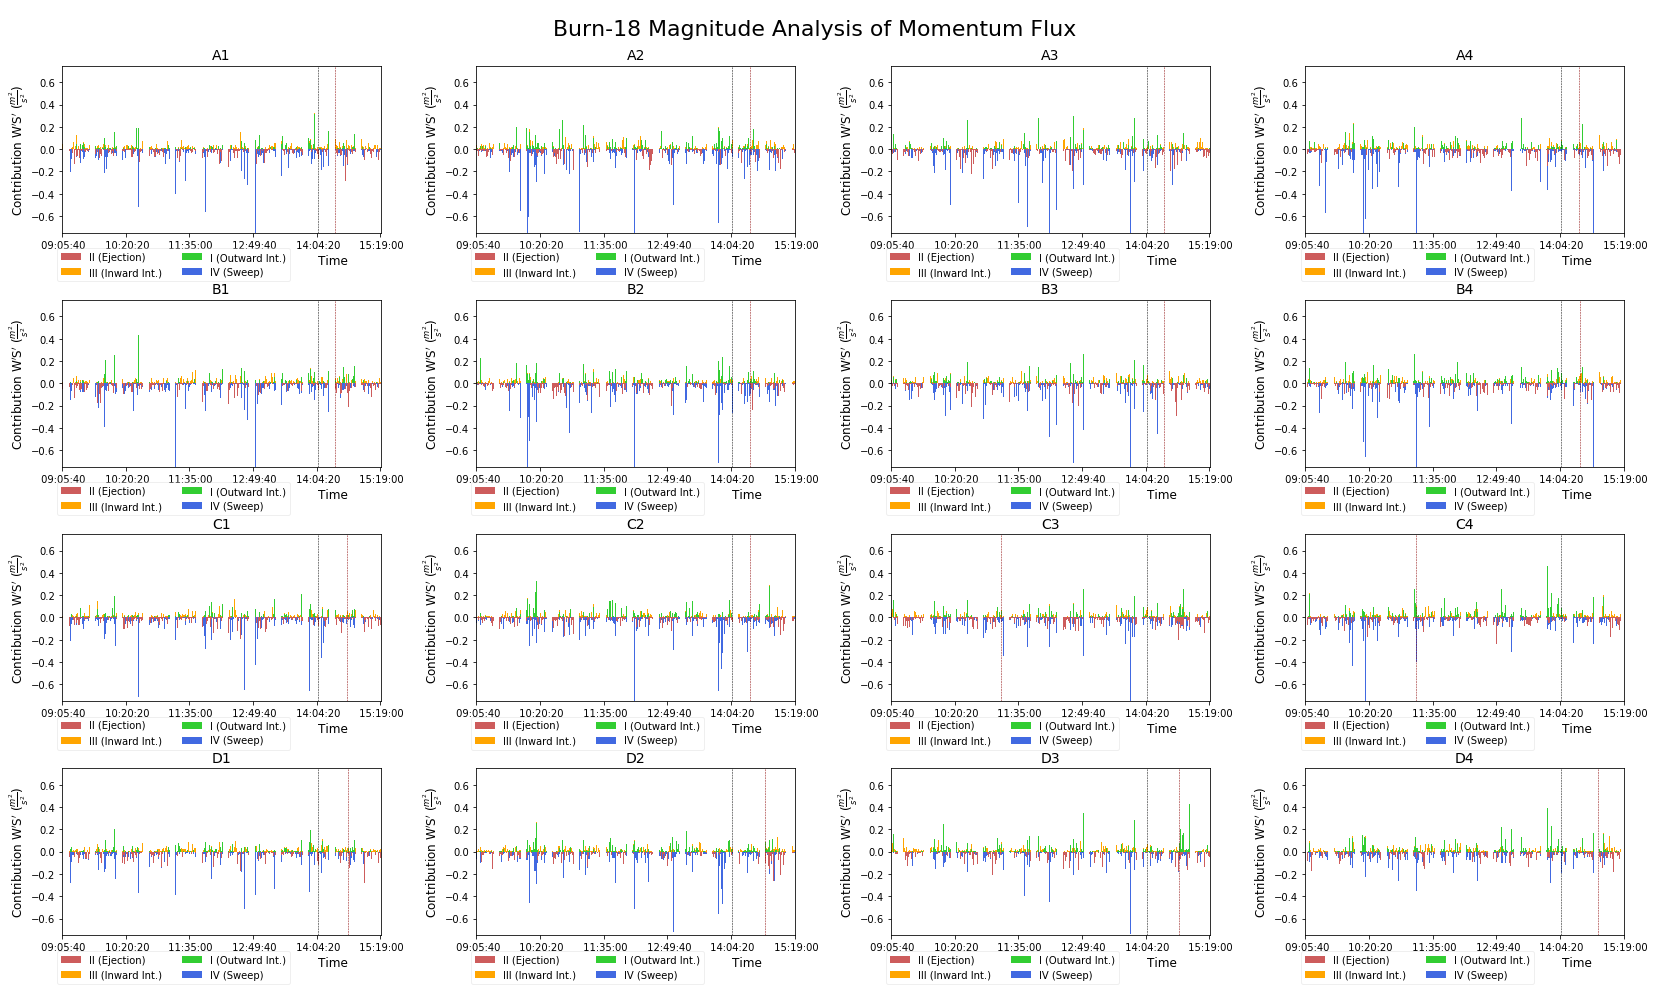

In [28]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-18/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,180000,"Burn-18")

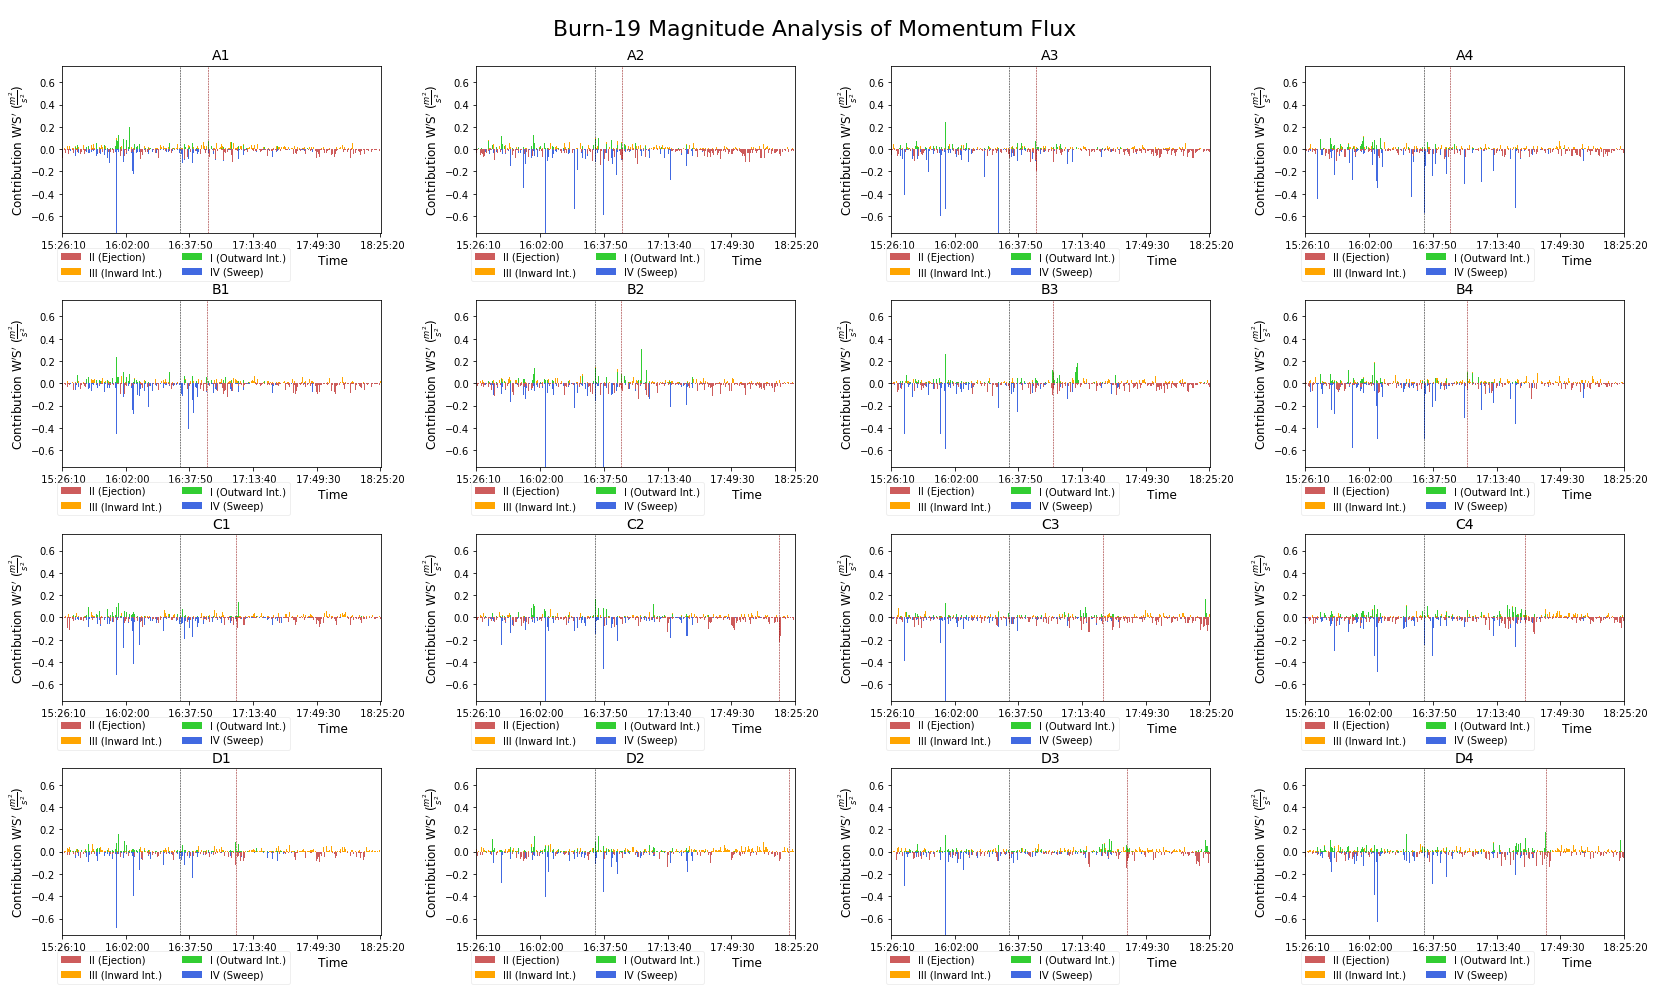

In [29]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-19/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,40000,"Burn-19")

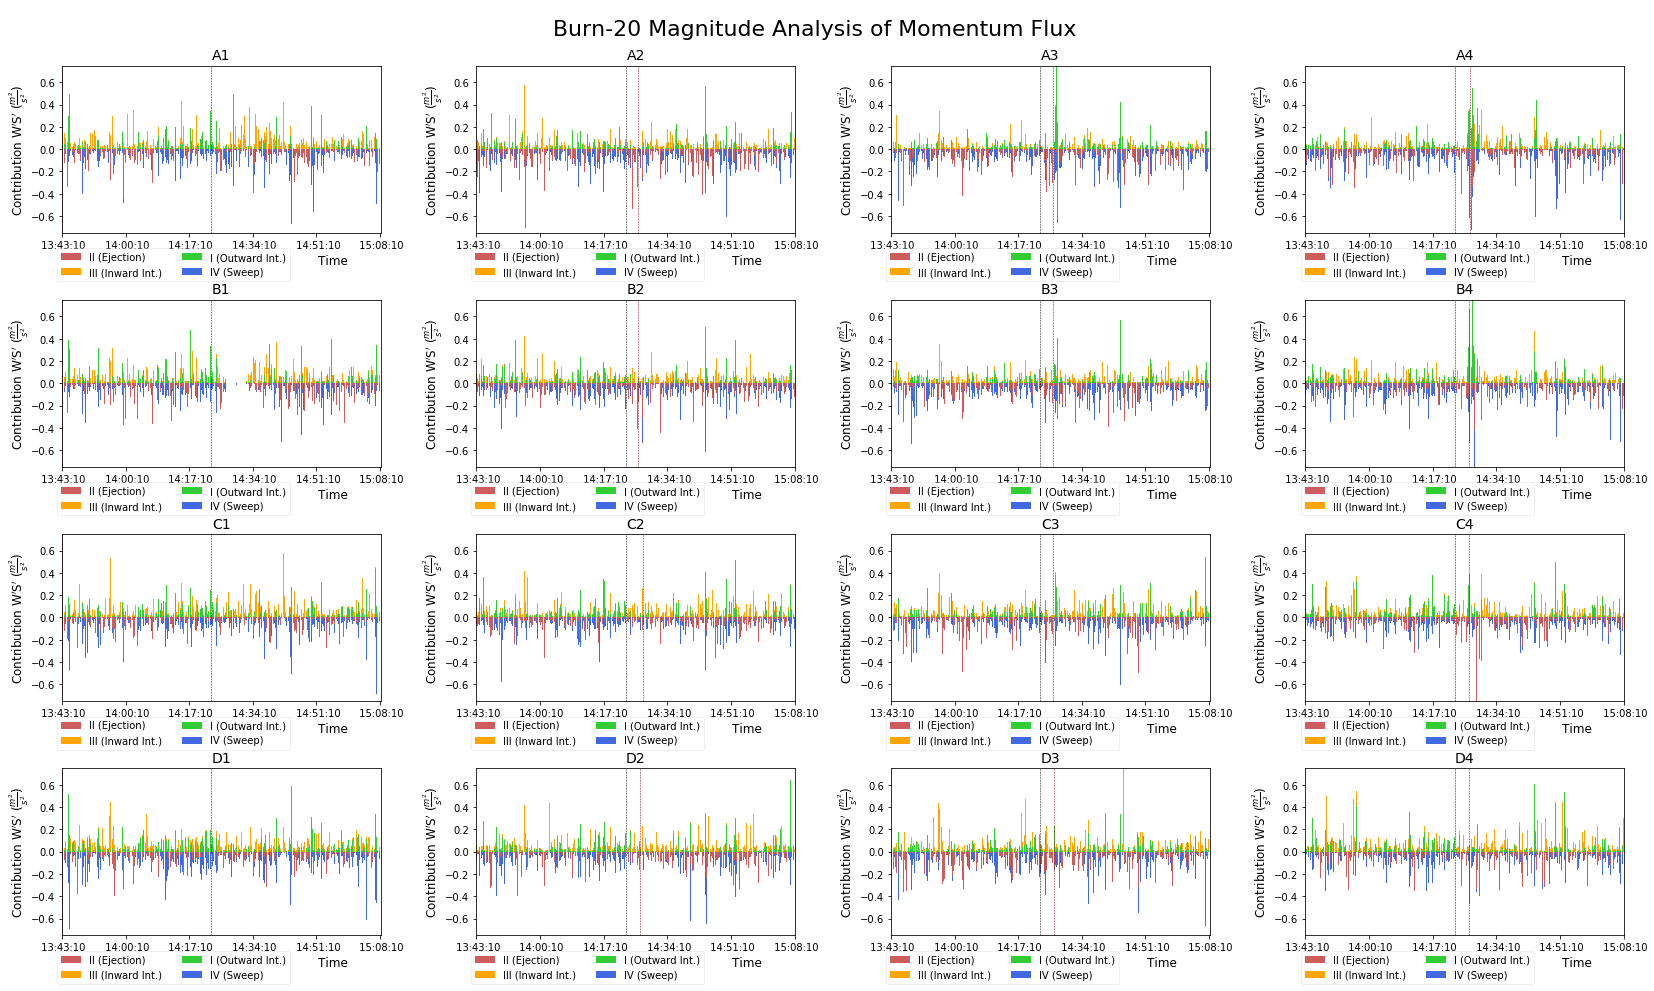

In [30]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-20/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,24000,"Burn-20")

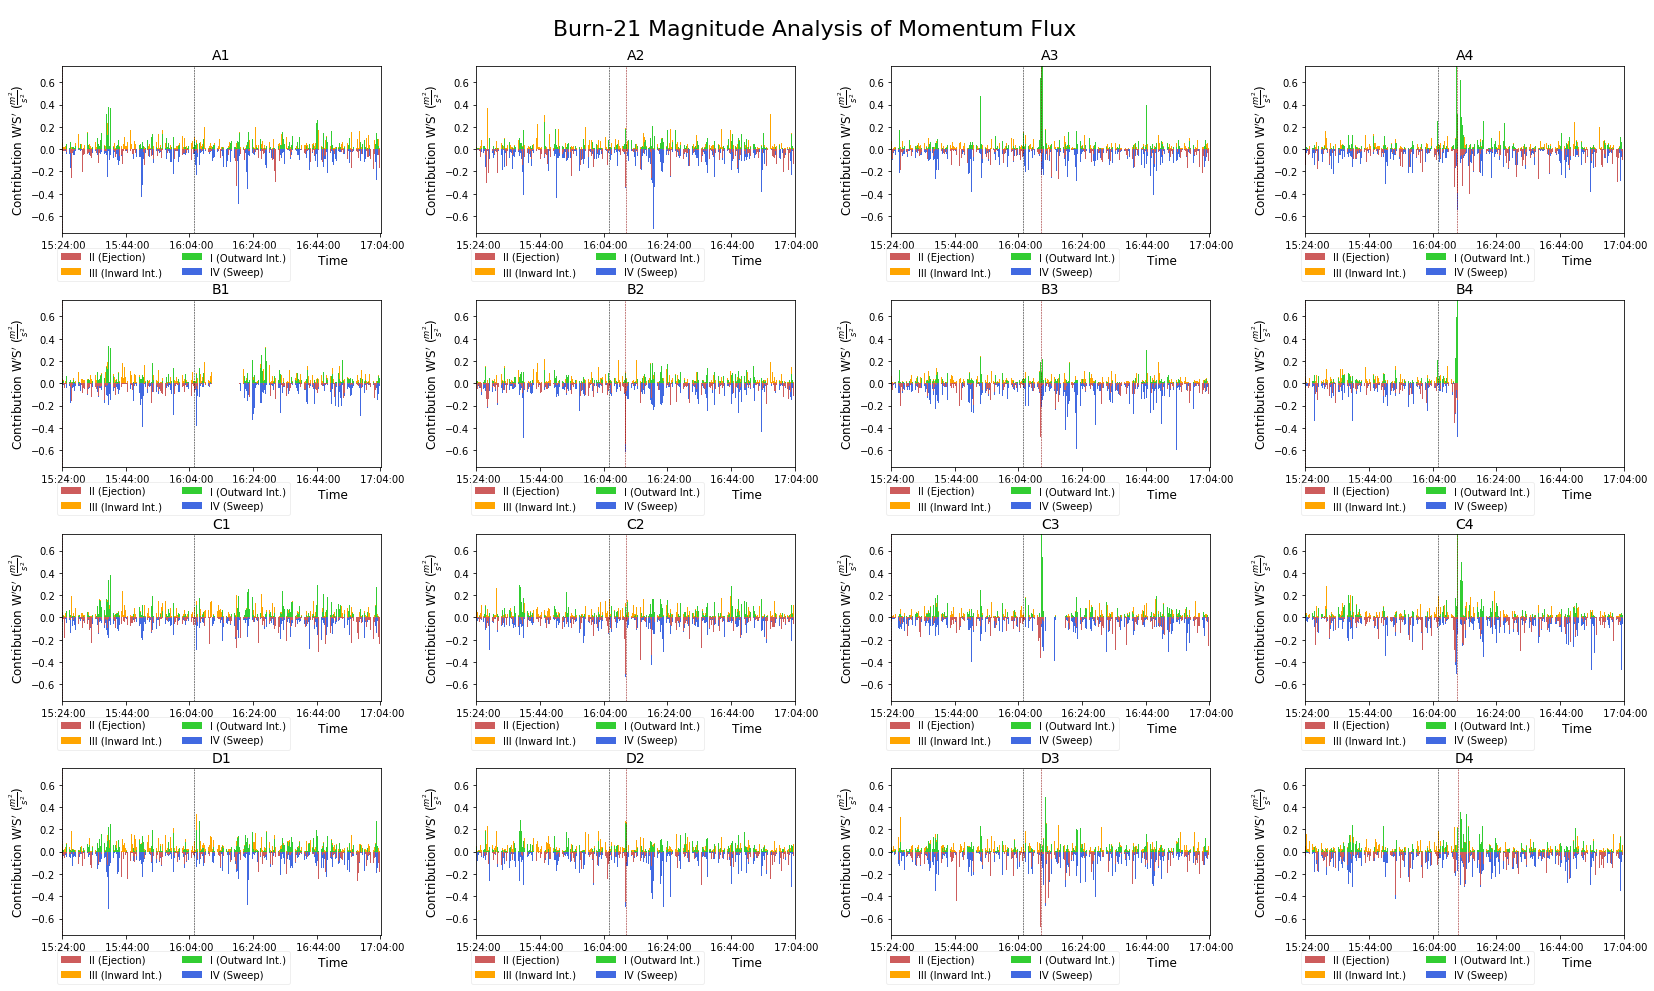

In [31]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-21/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-21")

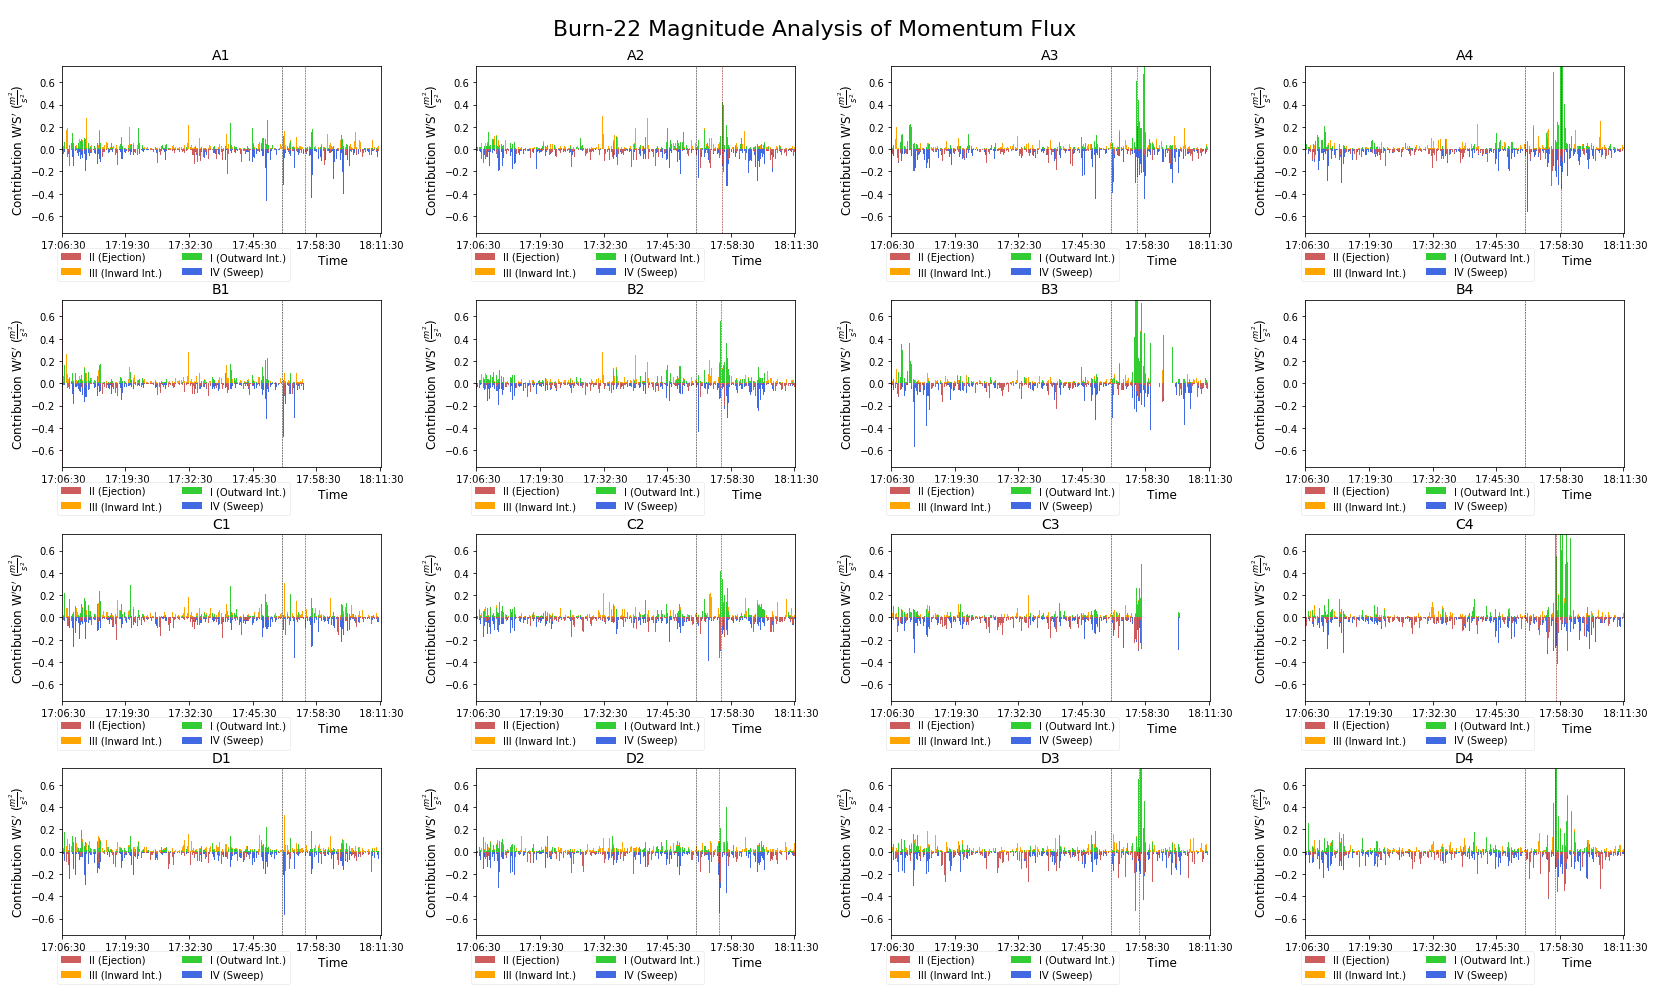

In [32]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-22/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,27000,"Burn-22")

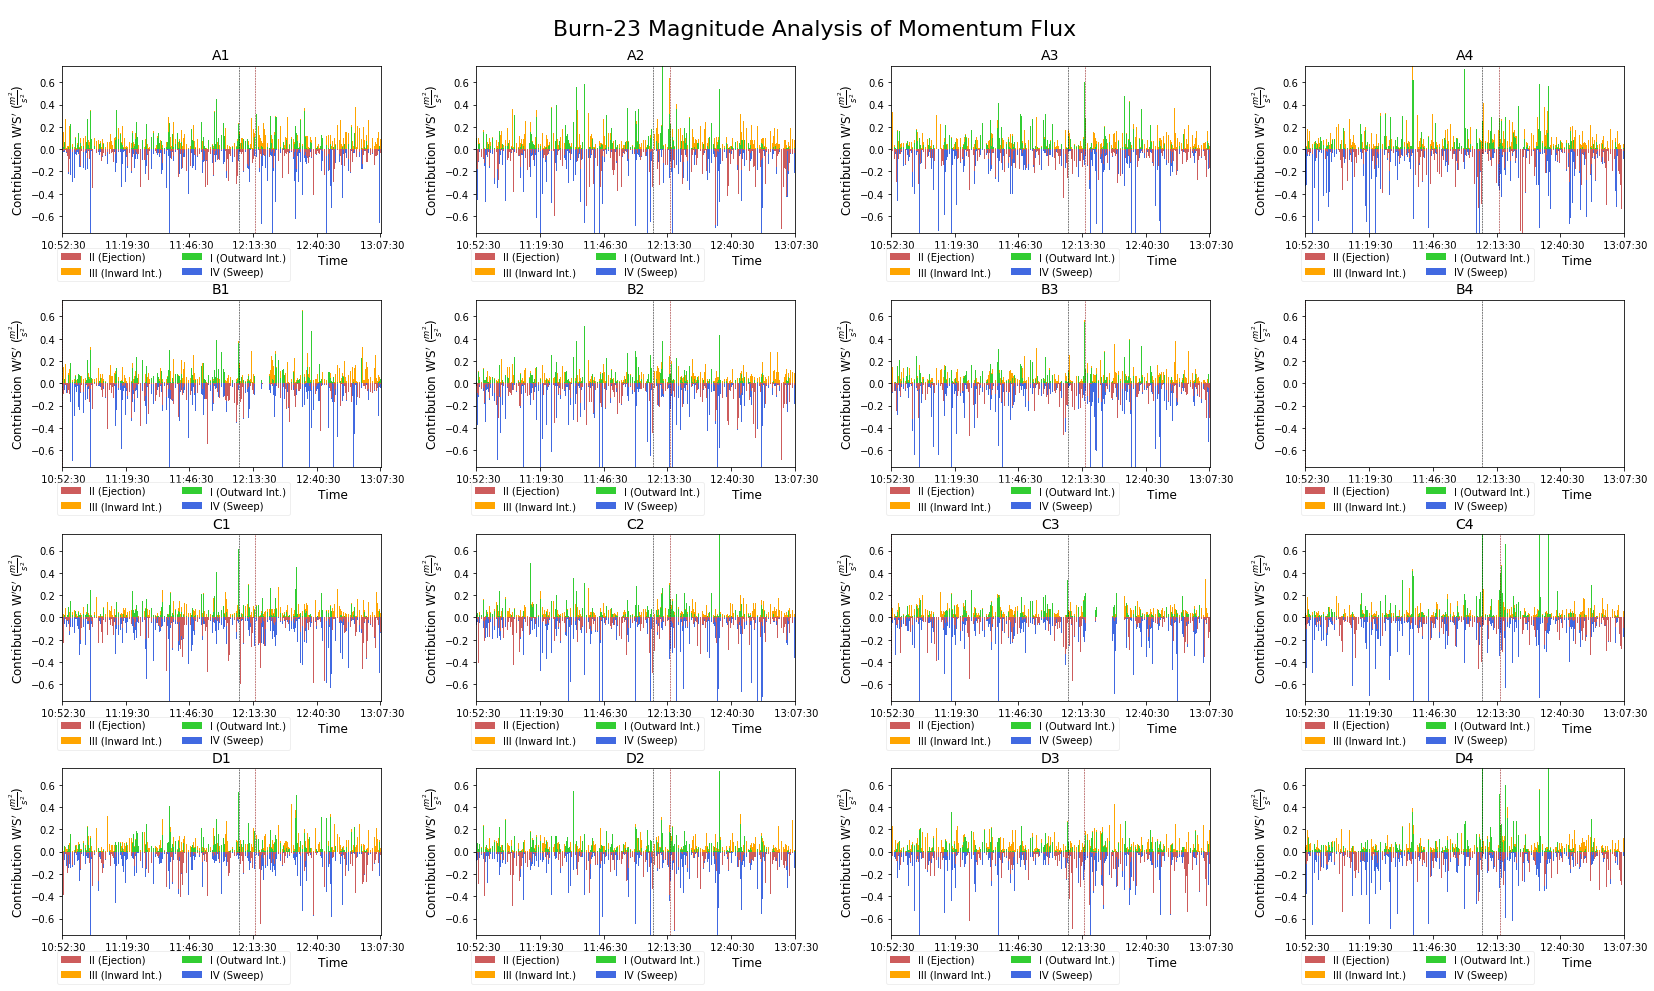

In [33]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-23/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,45000,"Burn-23")

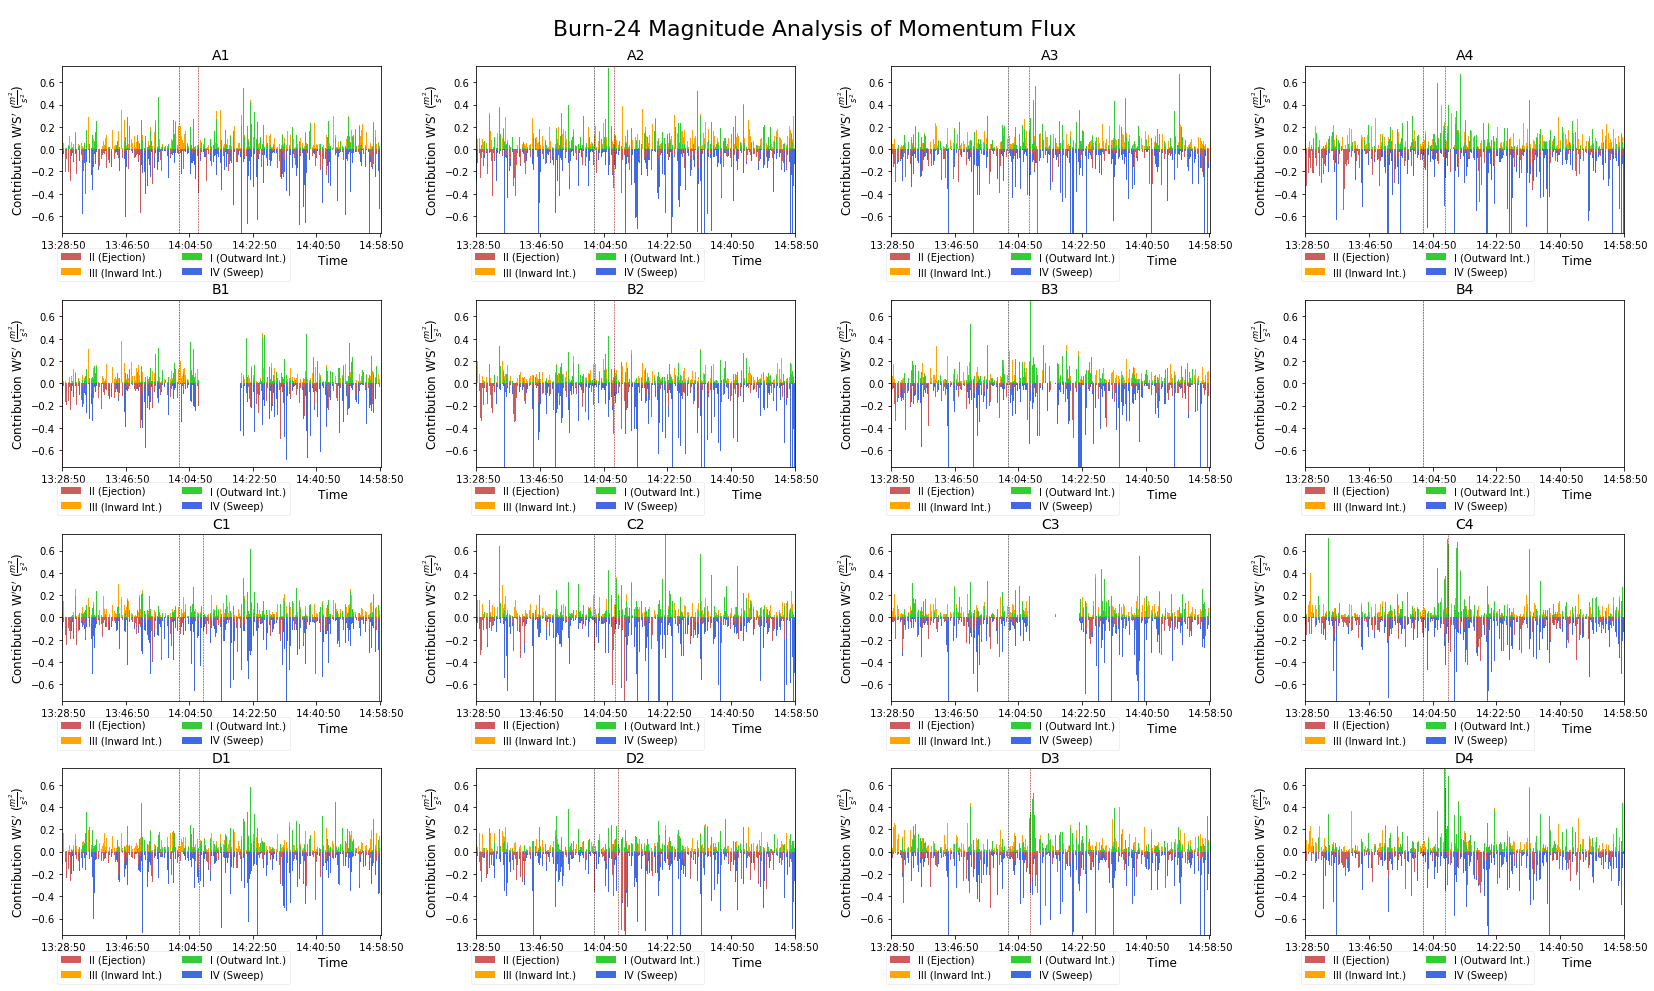

In [34]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-24/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,20000,"Burn-24")

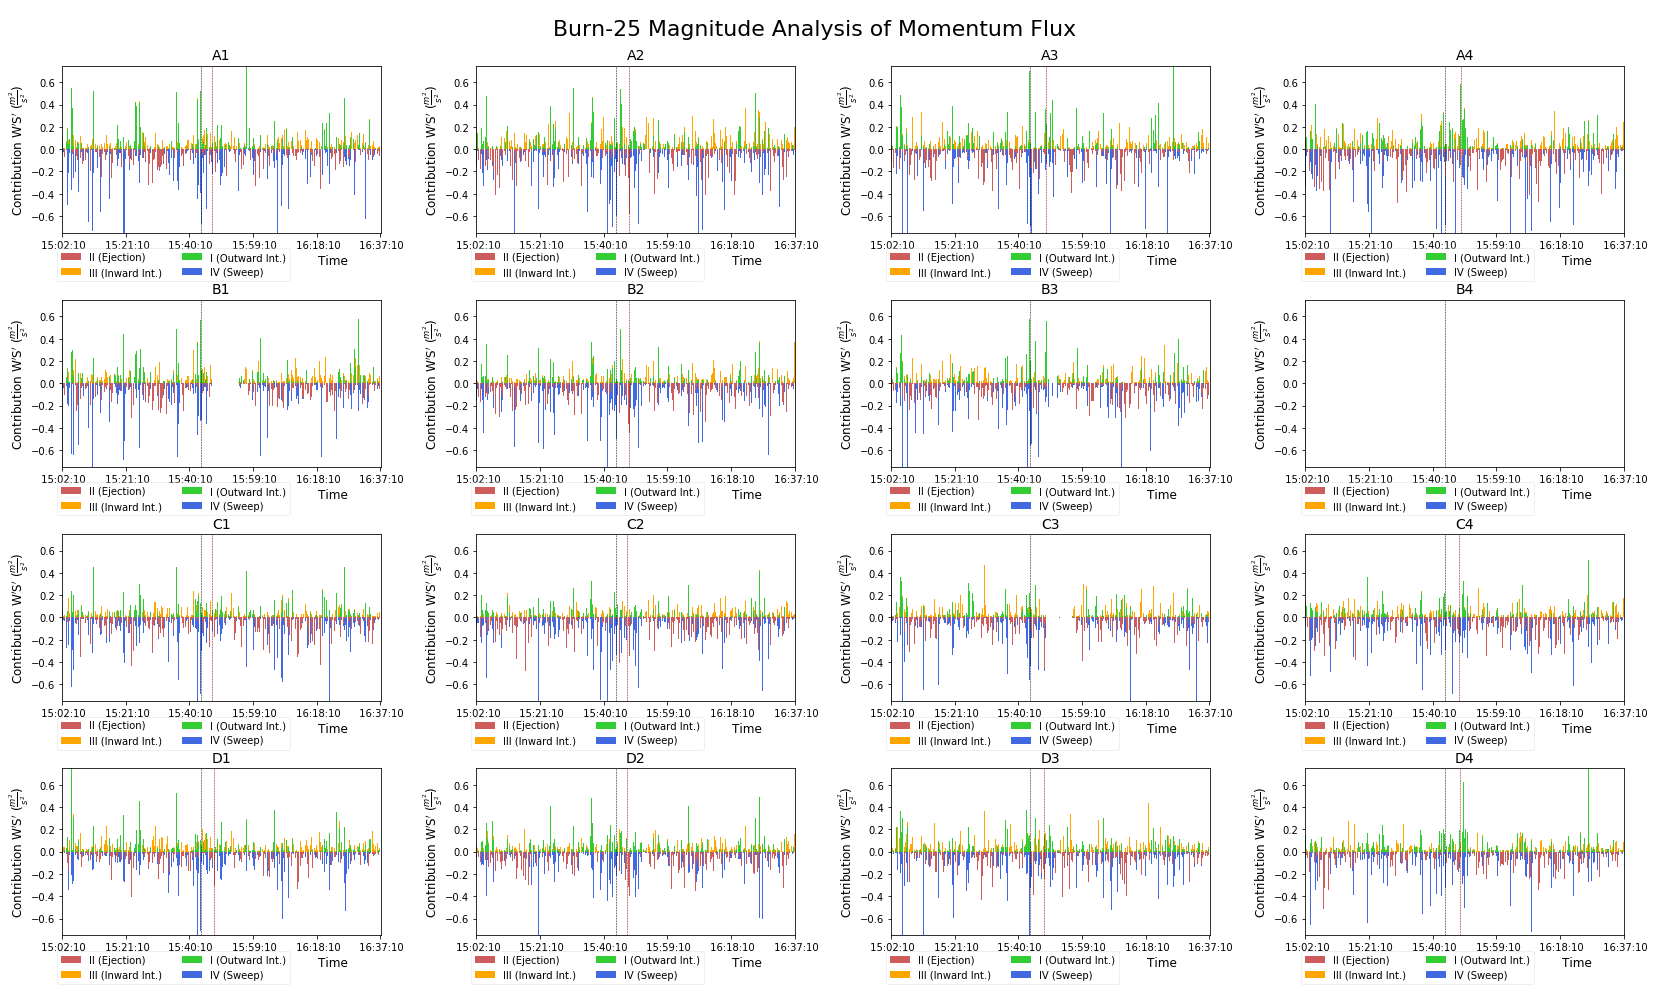

In [35]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-25/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-25")

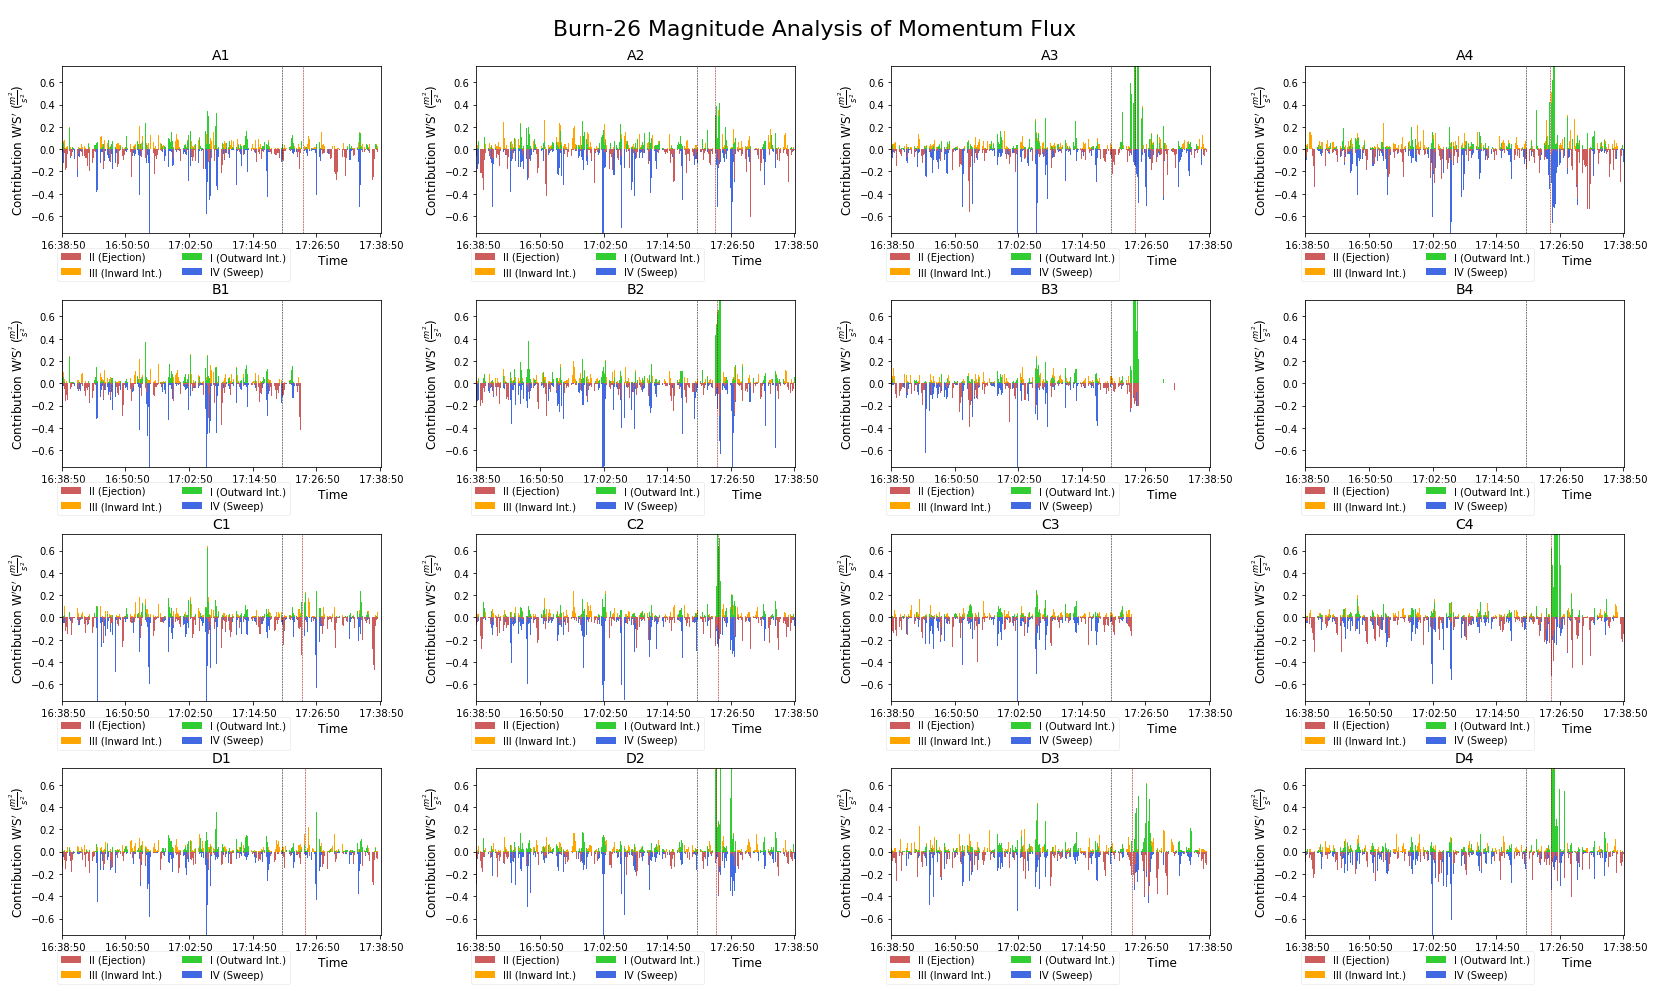

In [36]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-26/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-26")

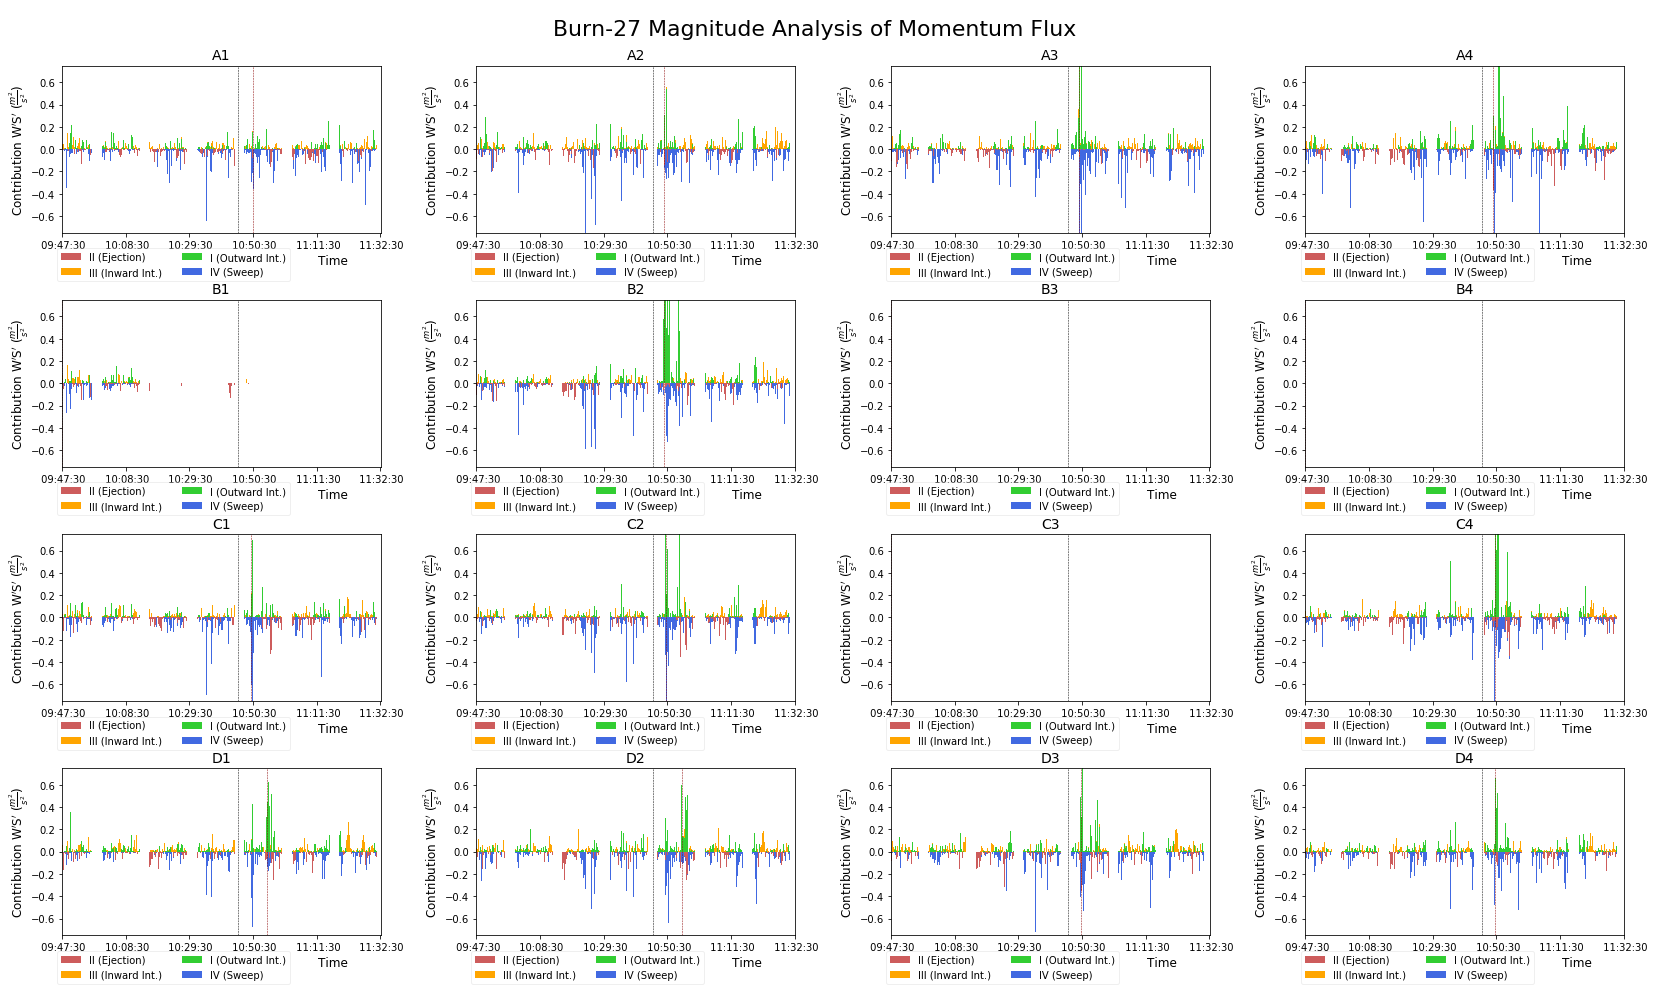

In [37]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-27/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,35000,"Burn-27")

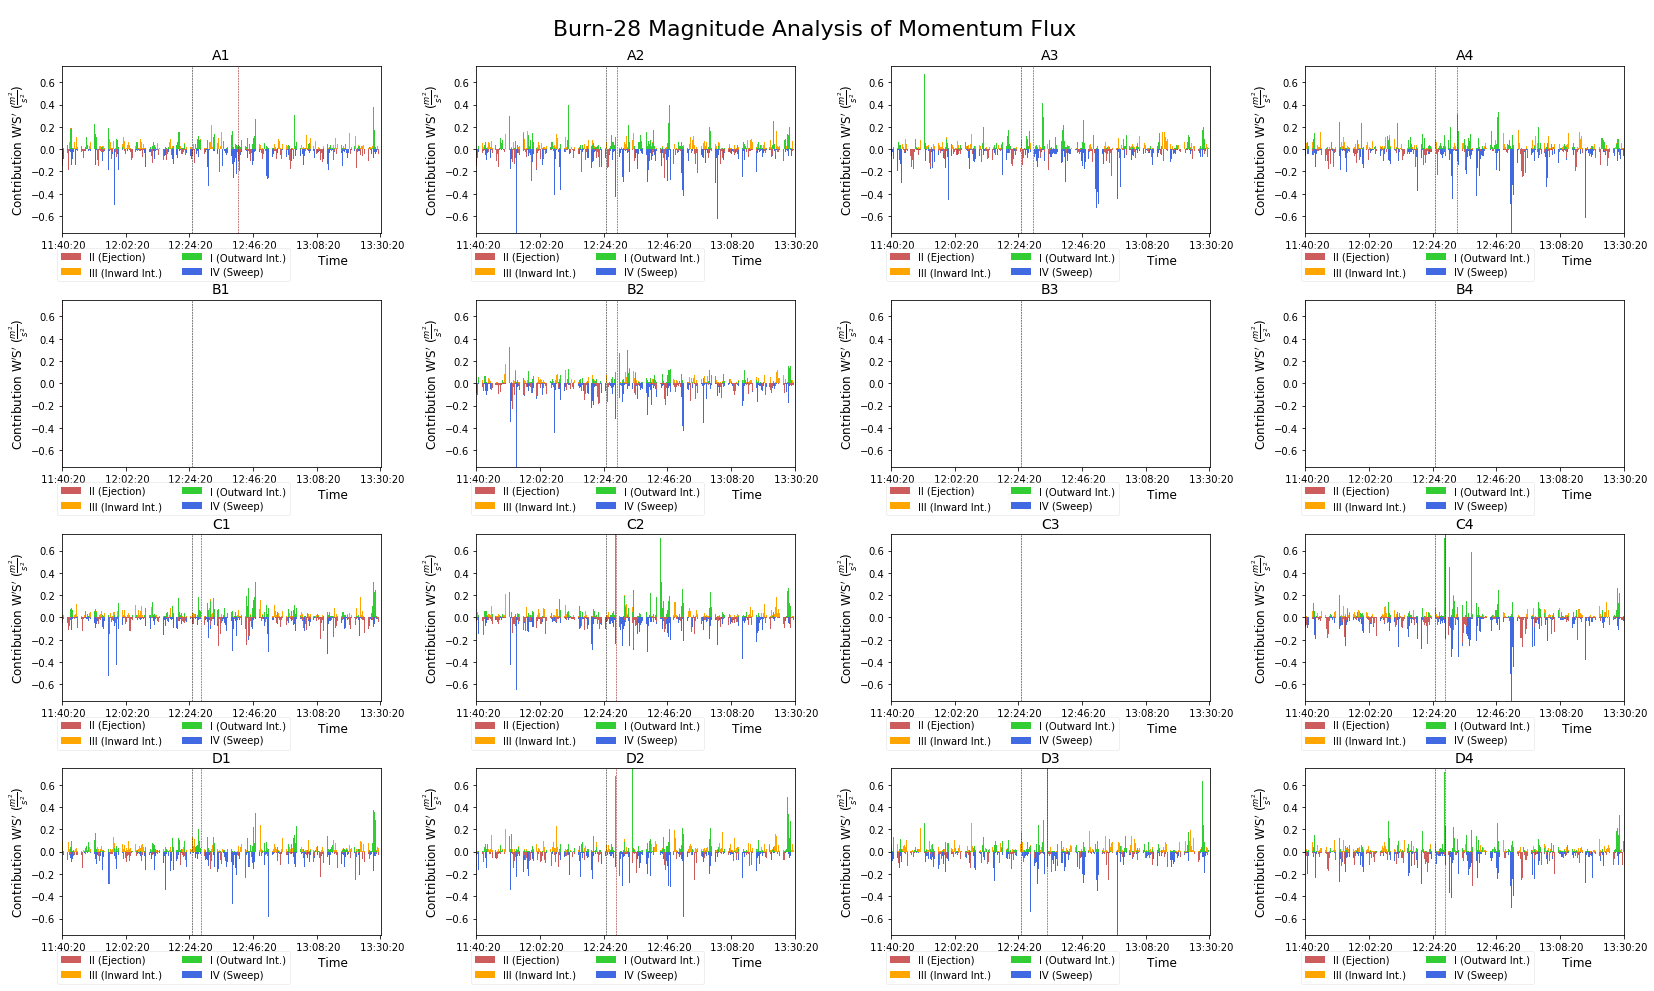

In [38]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-28/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,27000,"Burn-28")

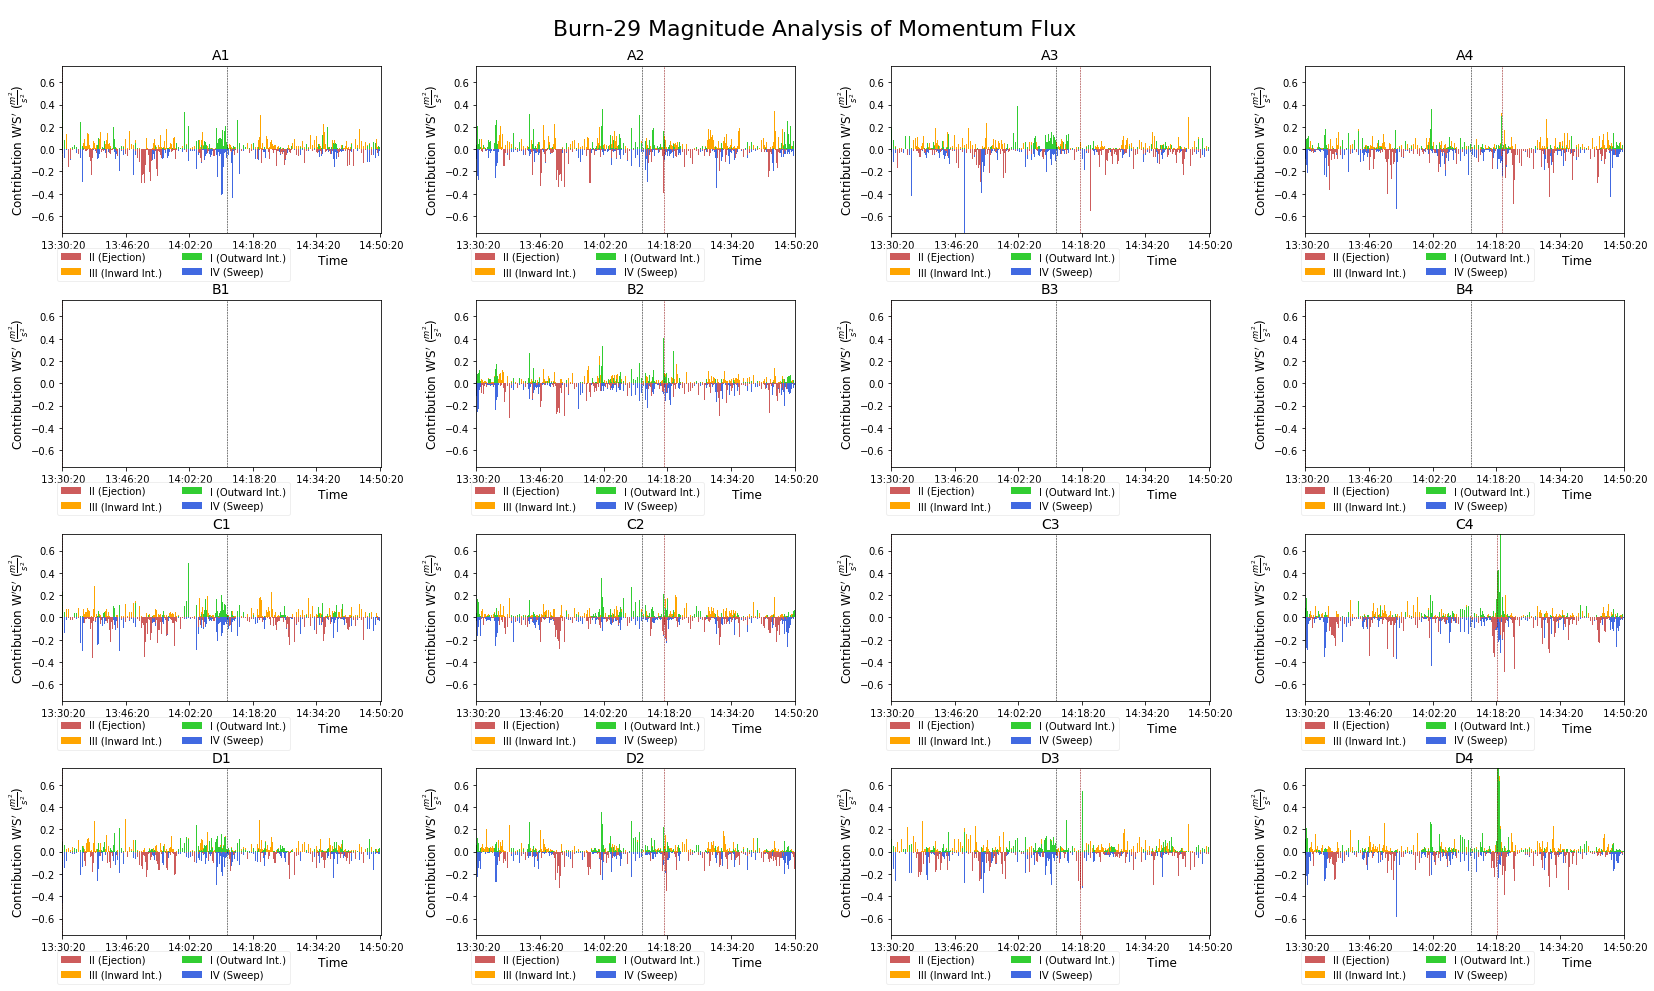

In [39]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-29/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,25000,"Burn-29")

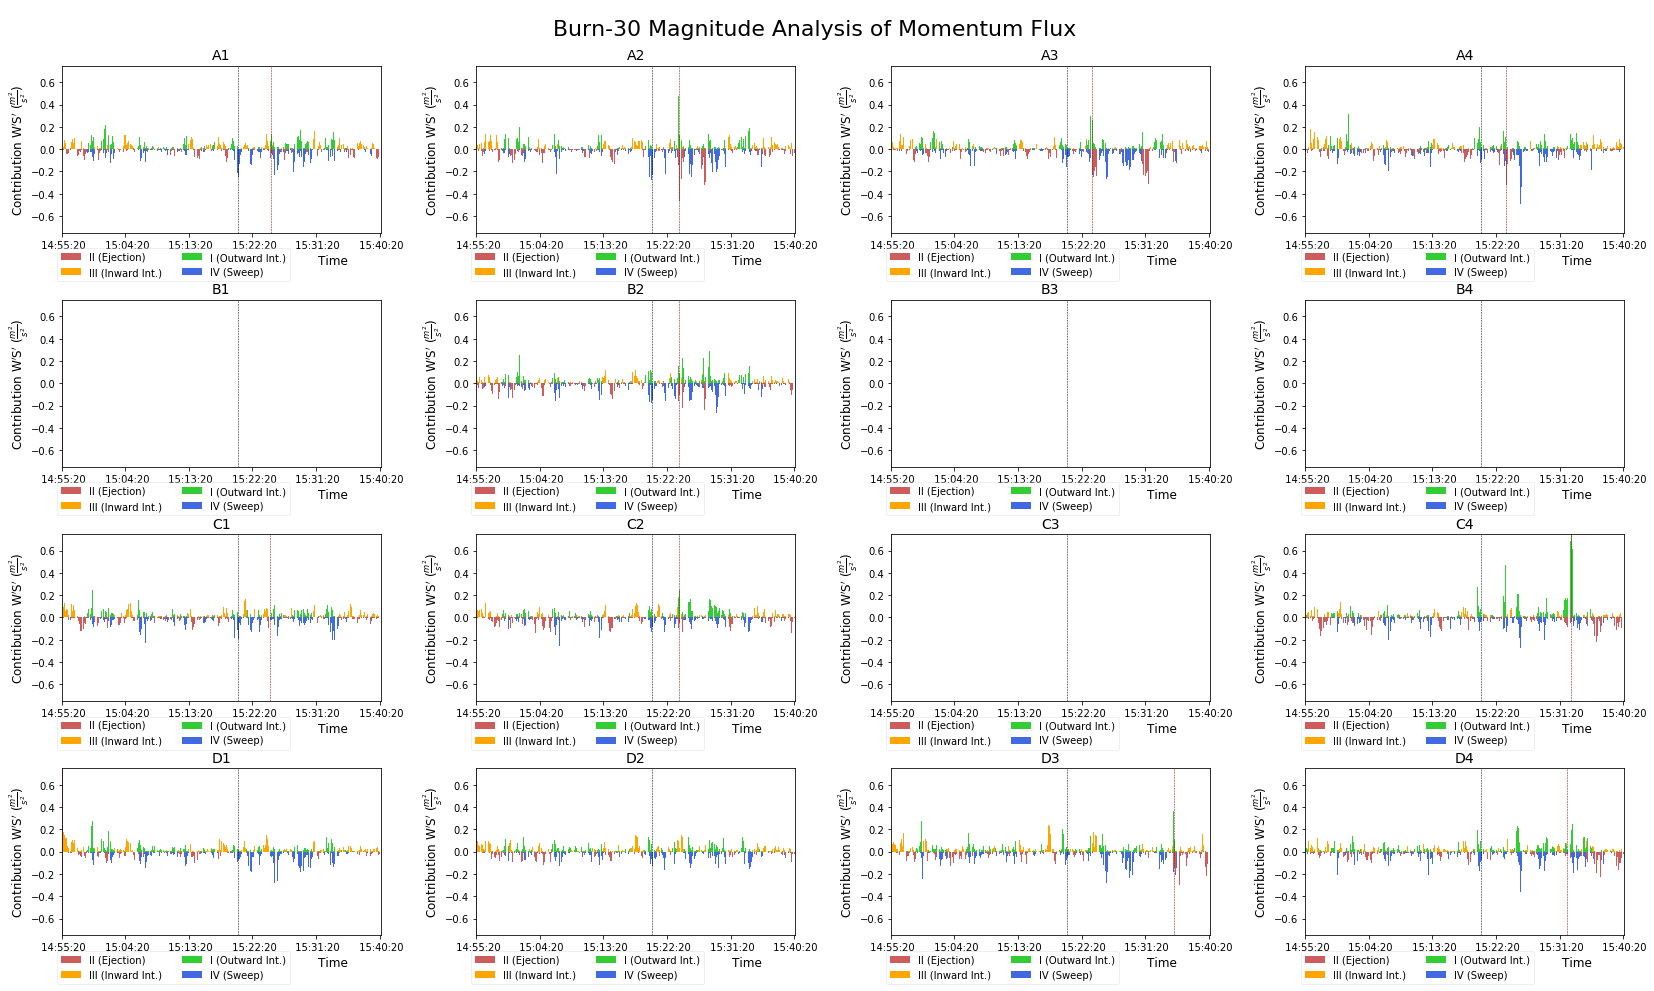

In [40]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-30/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,15000,"Burn-30")

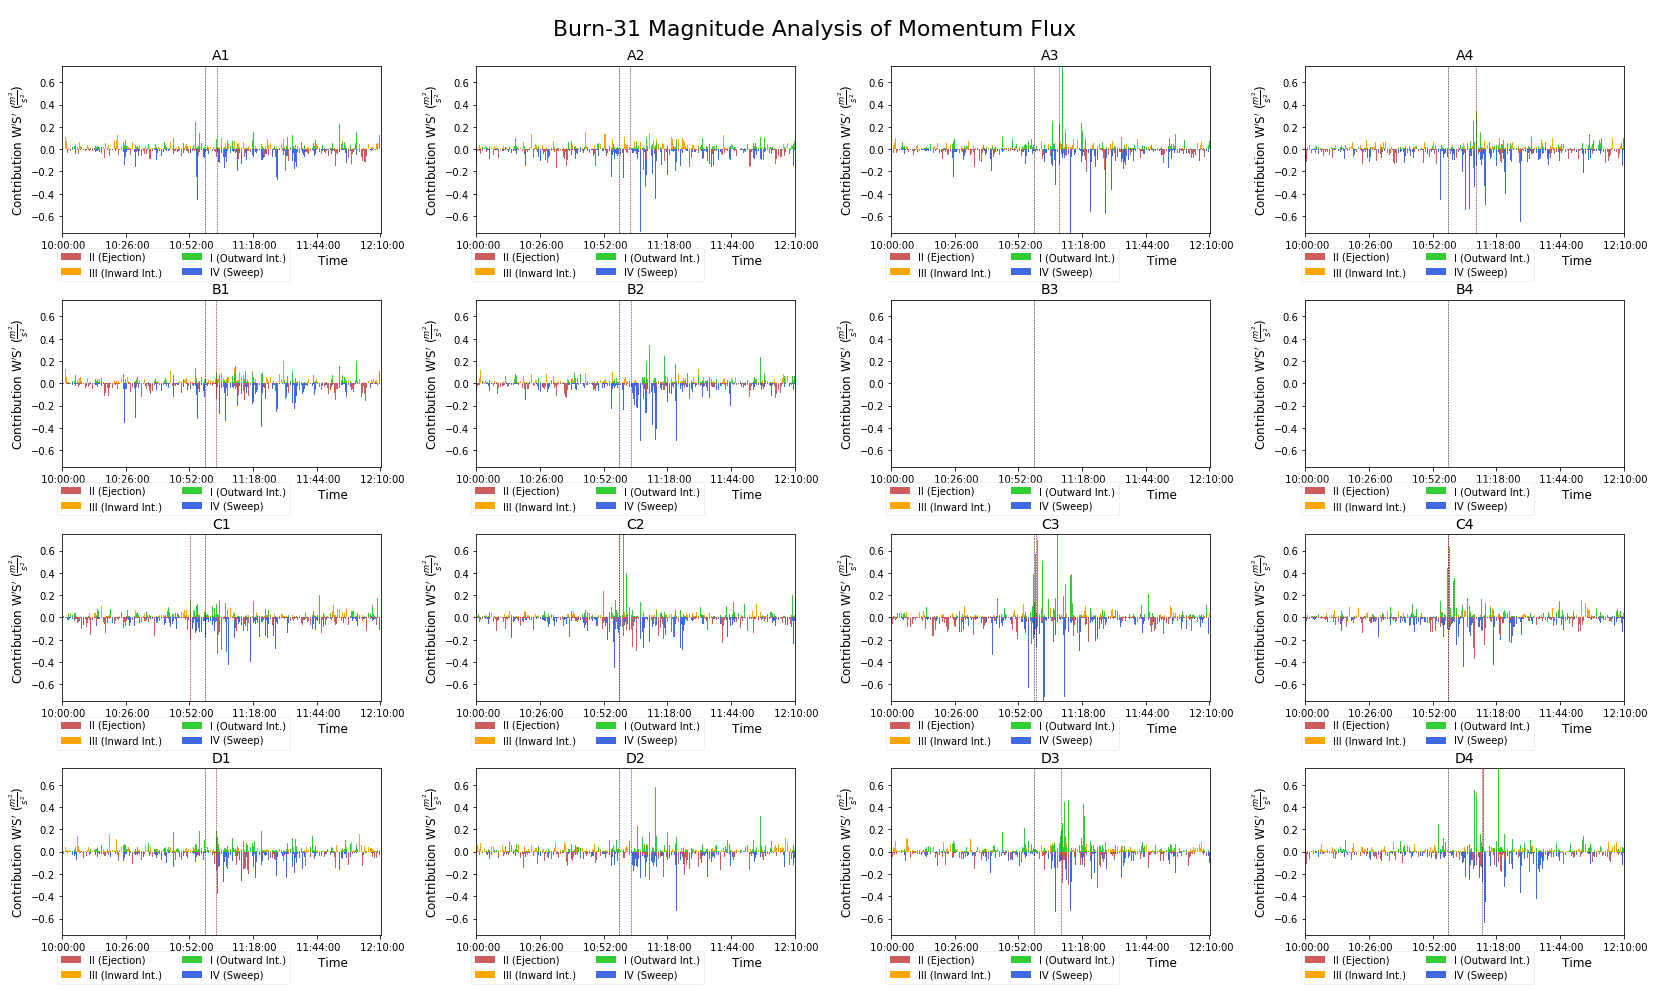

In [41]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-31/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,35000,"Burn-31")

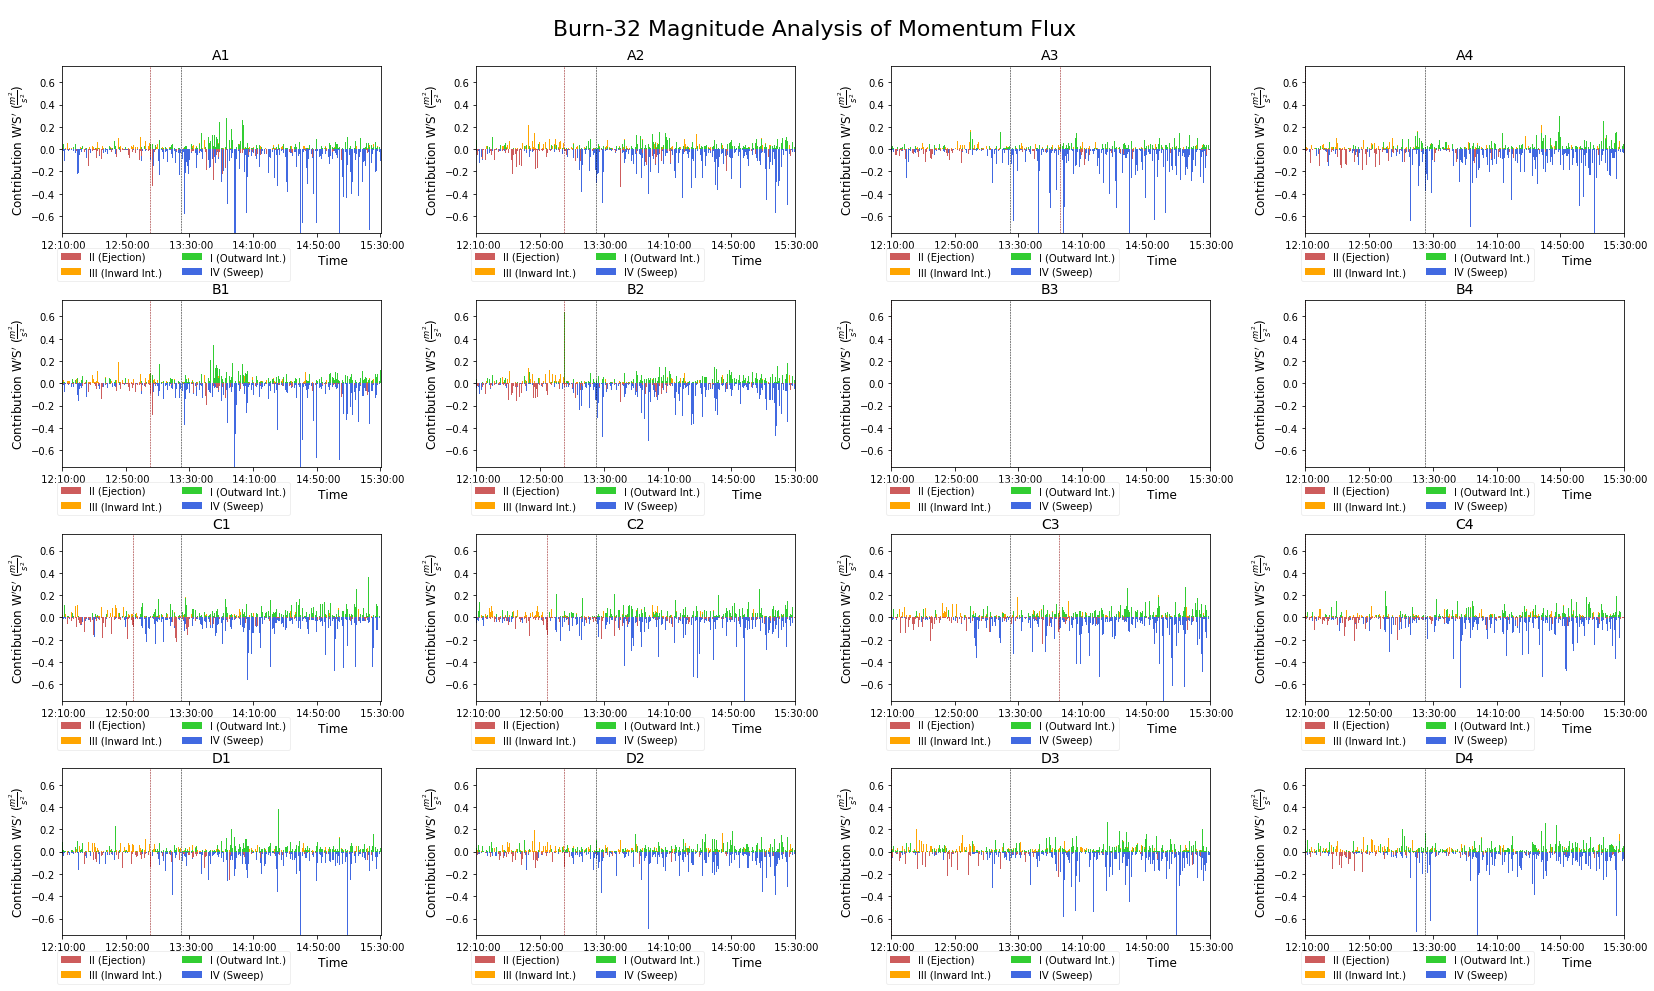

In [42]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-32/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,45000,"Burn-32")

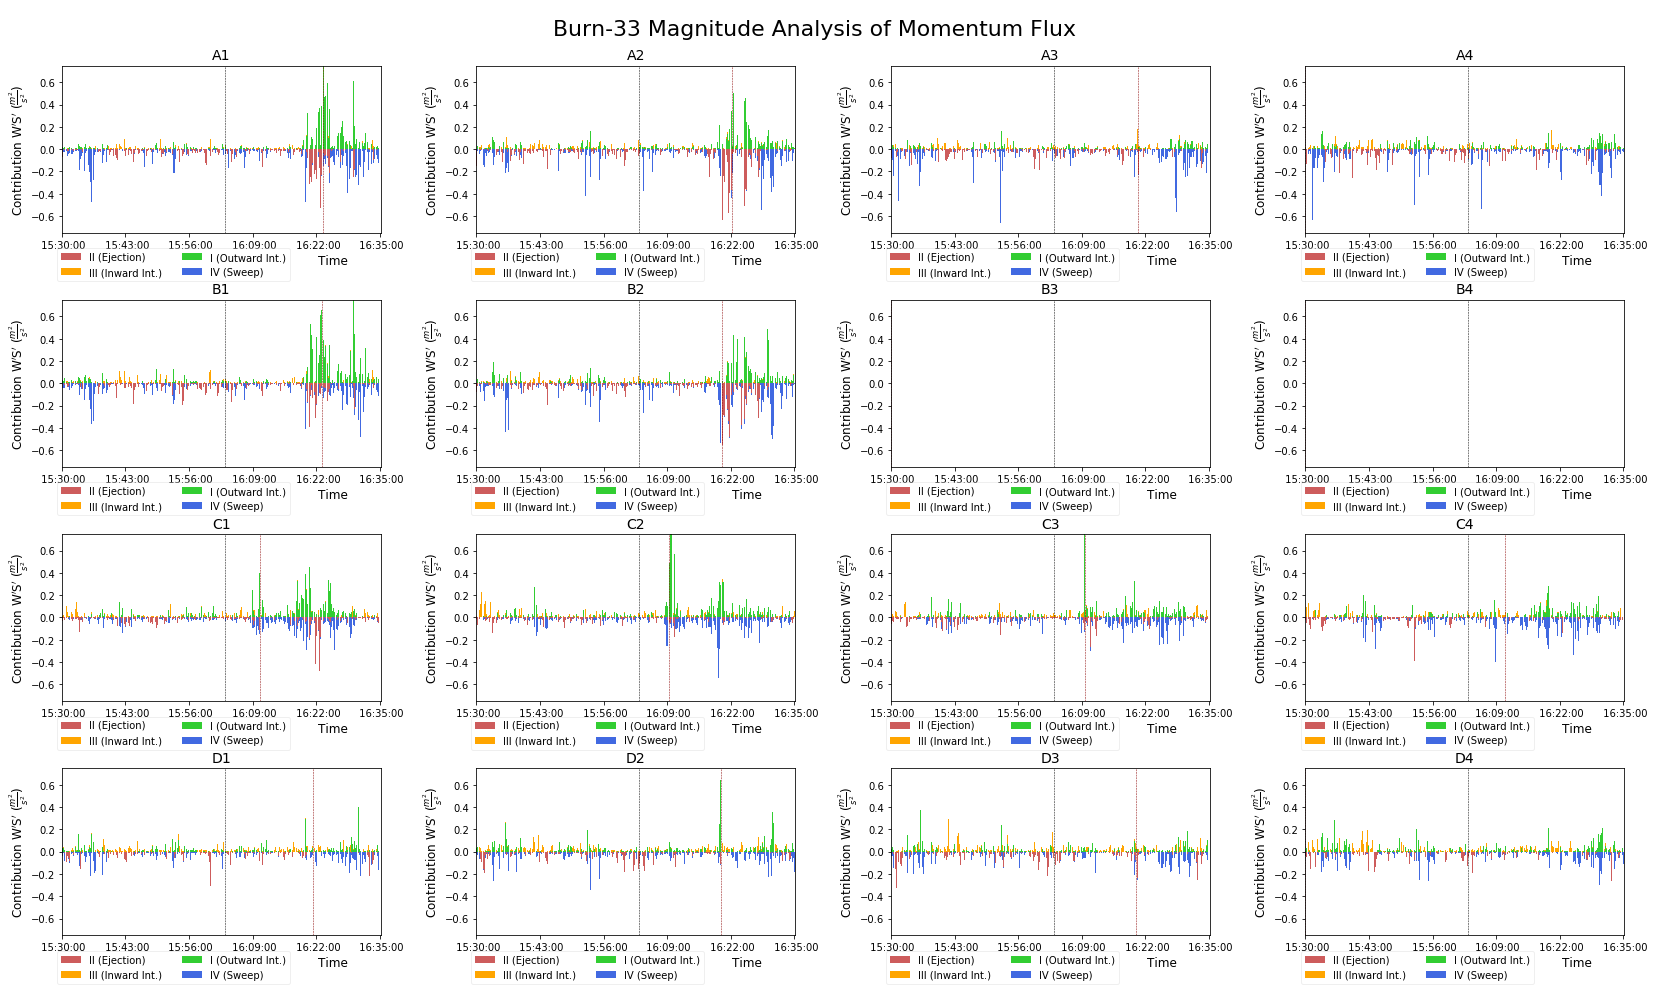

In [43]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-33/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,20000,"Burn-33")

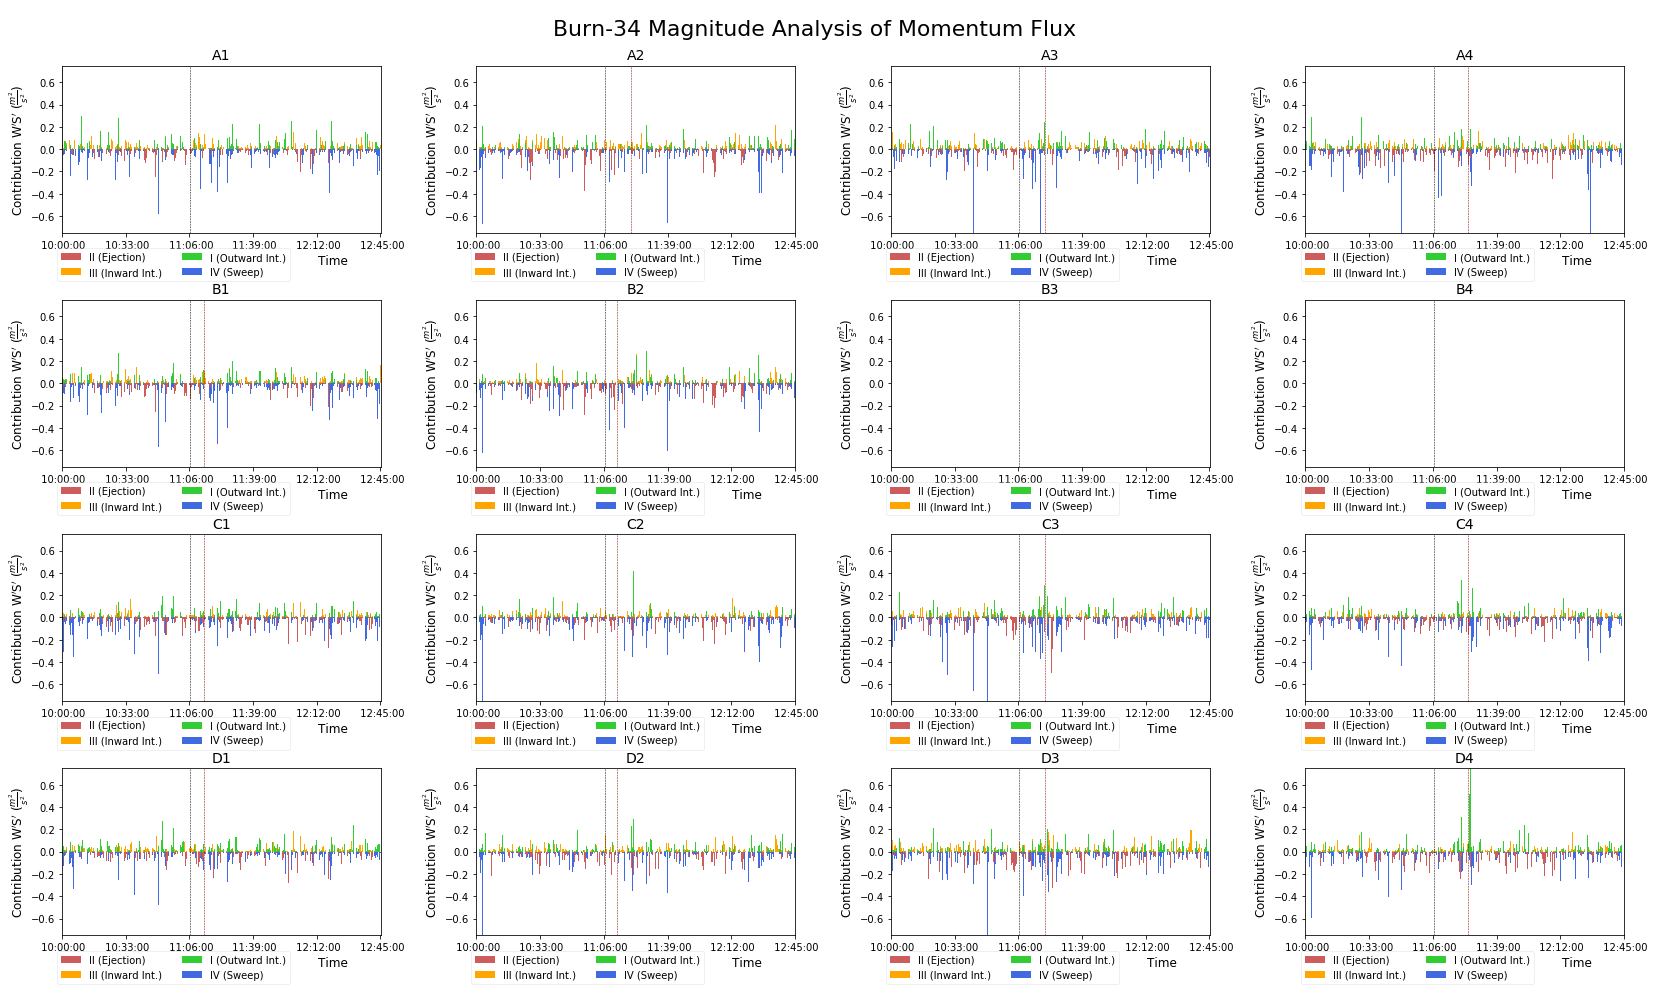

In [44]:
path="/home/joey/Desktop/10X10_Truss_SERDP_Burns/JS_Cleaned_Data/Burn-34/sonics/" #79 location
#path = "/Users/joeyp/Desktop/Forestry/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"
#path= "/home/JoeySeitz/10X10_Truss_SERDP_Burns_May_2018/JS_Cleaned_Data/Burn-13/sonics/"  #134 location

grid(path,40000,"Burn-34")